In [1]:
#just analyze ibmq_armonk. no other pulse providers.

In [2]:
from qiskit.tools.jupyter import *

In [3]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

C:\Users\johnn\.julia\conda\3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [4]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [5]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [6]:
backend_defaults = backend.defaults()

In [7]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.97186208283383 GHz.
The sweep will go from 4.95186208283383 GHz to 4.99186208283383 GHz in steps of 1.0 MHz.


In [8]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [9]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
# This Pulse module helps us build sampled pulses for common pulse shapes
from qiskit.pulse import library as pulse_lib


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.05
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In [10]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [11]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [12]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [13]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

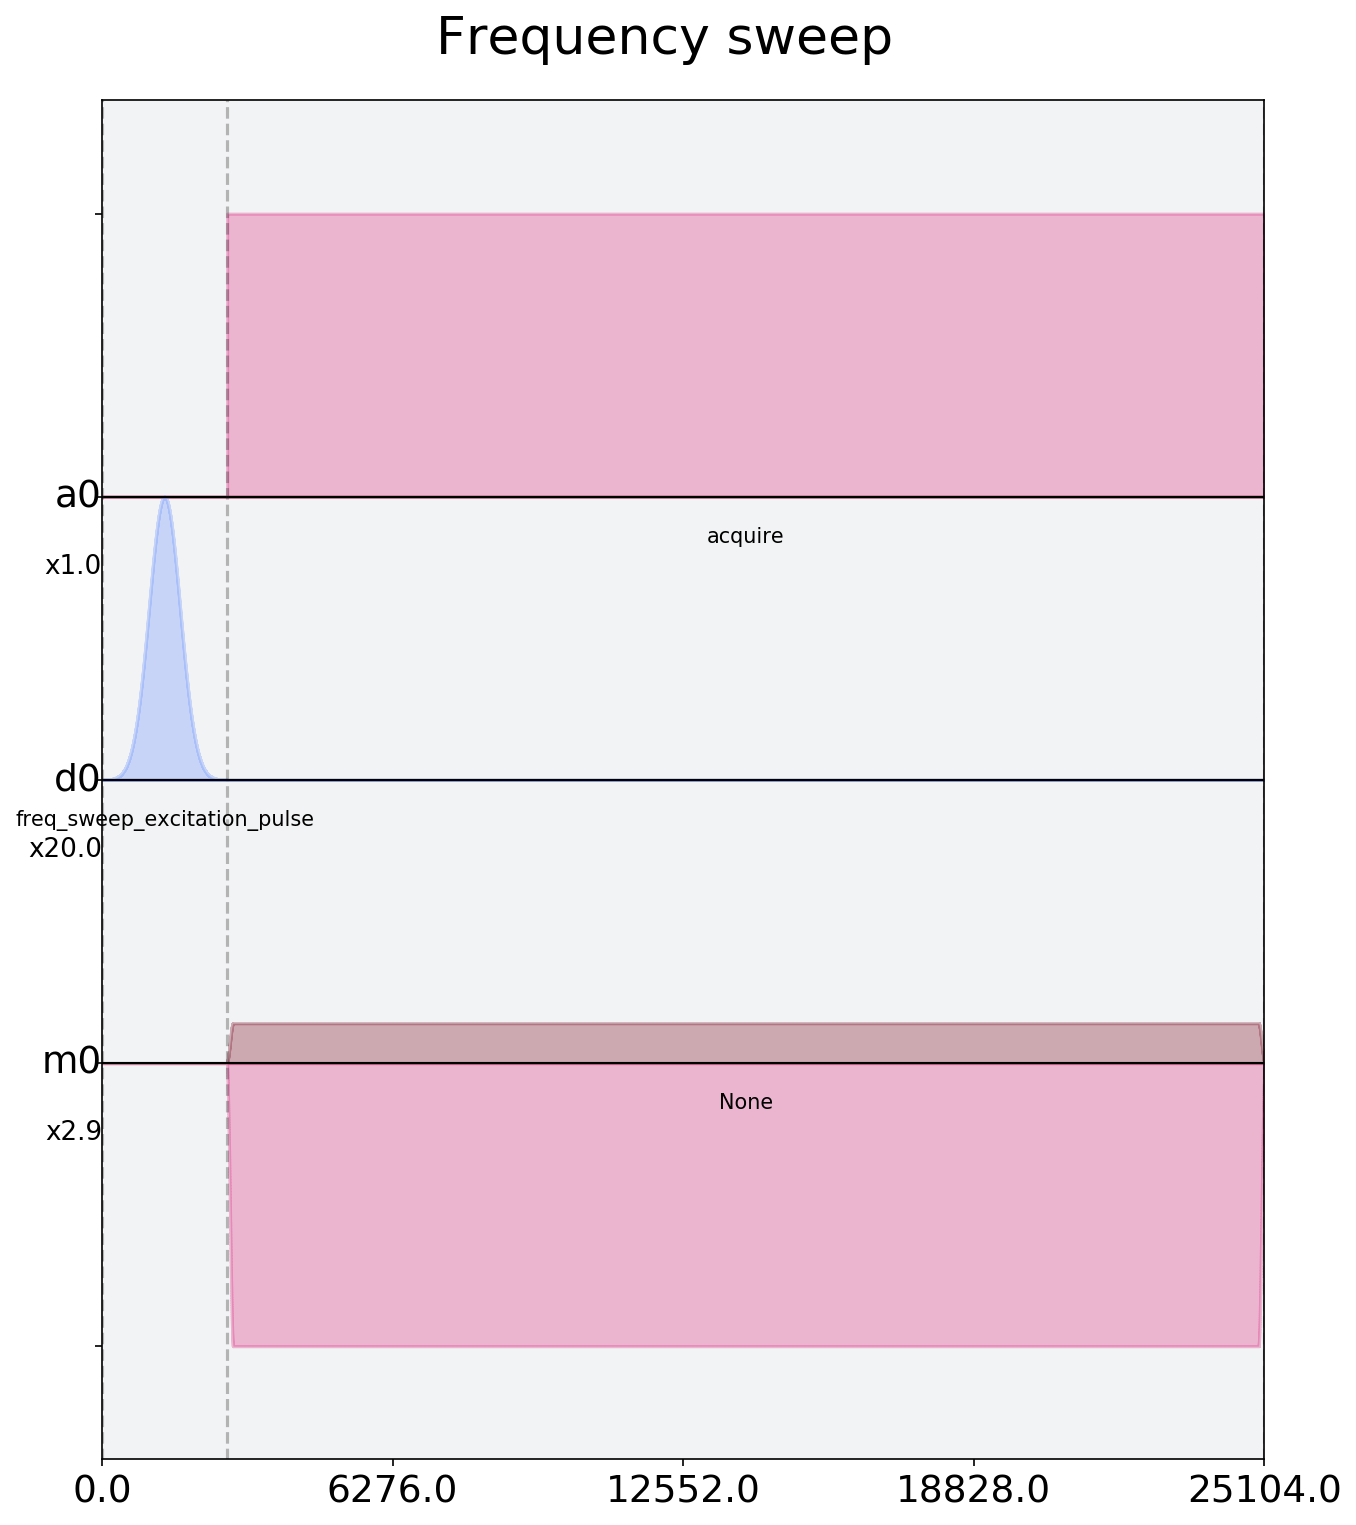

In [14]:
schedule.draw(label=True)

In [15]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

In [16]:
job = backend.run(frequency_sweep_program)

In [17]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [18]:
job2 = backend.run(frequency_sweep_program)

In [19]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job2)

Job Status: job has successfully run


In [20]:
job3 = backend.run(frequency_sweep_program)

In [21]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job3)

Job Status: job has successfully run


In [22]:
job4 = backend.run(frequency_sweep_program)

In [23]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job4)

Job Status: job has successfully run


In [24]:
job5 = backend.run(frequency_sweep_program)

In [25]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job5)

Job Status: job has successfully run


In [68]:
frequency_sweep_results = job.result(timeout=120)

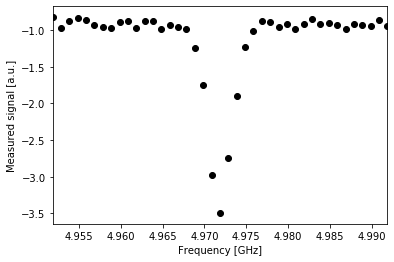

In [69]:
import matplotlib.pyplot as plt

sweep_values = []
sweep_values1 = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])
    sweep_values1.append(res[qubit])
sweep_values1 = np.real(sweep_values1)

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [70]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [71]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.975, 1, 5] # initial parameters for curve_fit
                                )

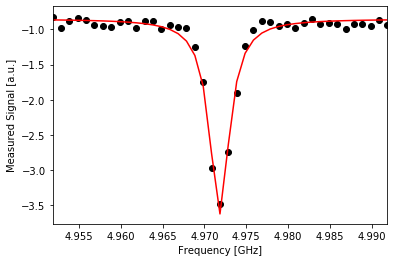

In [72]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [73]:
A, rough_qubit_frequency1, B, C = fit_params
rough_qubit_frequency1 = rough_qubit_frequency1*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency1/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97186 GHz to 4.97181 GHz.


In [74]:
fit_params1 = fit_params

In [75]:
frequency_sweep_results = job2.result(timeout=120)

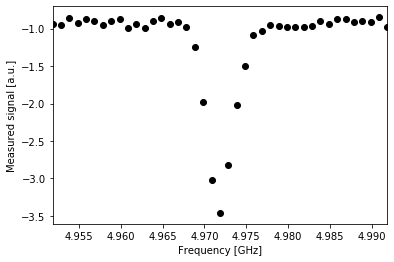

In [76]:
import matplotlib.pyplot as plt

sweep_values = []
sweep_values2 = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])
    sweep_values2.append(res[qubit])
sweep_values2 = np.real(sweep_values2)

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [77]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.972, 1, 5] # initial parameters for curve_fit
                                )

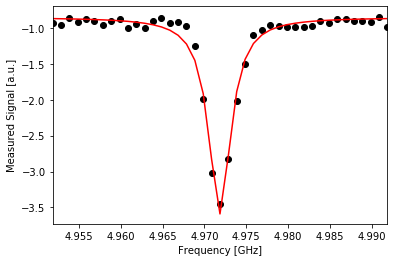

In [78]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [79]:
A, rough_qubit_frequency2, B, C = fit_params
rough_qubit_frequency2 = rough_qubit_frequency2*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency2 / GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97186 GHz to 4.97184 GHz.


In [80]:
fit_params2 = fit_params

In [81]:
frequency_sweep_results = job3.result(timeout=120)

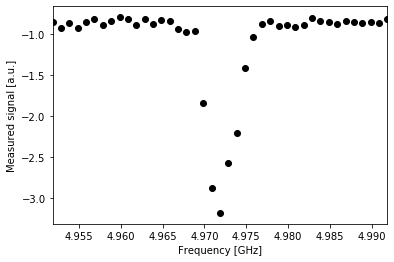

In [82]:
import matplotlib.pyplot as plt

sweep_values = []
sweep_values3 = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])
    sweep_values3.append(res[qubit])
sweep_values3 = np.real(sweep_values3)

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [83]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.972, 1, 5] # initial parameters for curve_fit
                                )

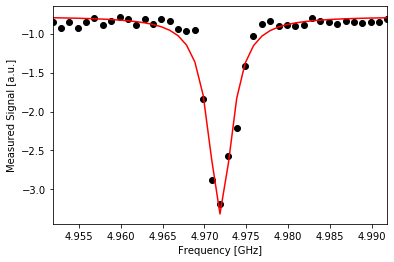

In [84]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [85]:
A, rough_qubit_frequency2, B, C = fit_params
rough_qubit_frequency1 = rough_qubit_frequency1*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency2, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97186 GHz to 4.97189 GHz.


In [86]:
fit_params3 = fit_params

In [87]:
frequency_sweep_results = job4.result(timeout=120)

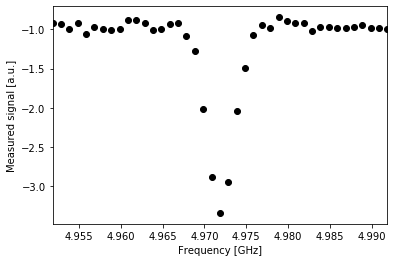

In [88]:
import matplotlib.pyplot as plt

sweep_values = []
sweep_values4 = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])
    sweep_values4.append(res[qubit])
sweep_values4 = np.real(sweep_values4)

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [89]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.972, 1, 5] # initial parameters for curve_fit
                                )

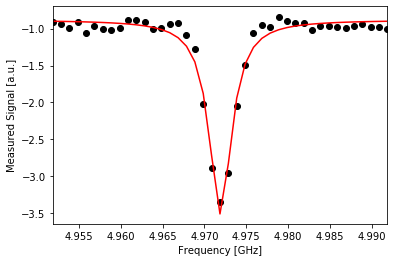

In [90]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [91]:
A, rough_qubit_frequency2, B, C = fit_params
rough_qubit_frequency2 = rough_qubit_frequency2*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency2 / GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97186 GHz to 4.97191 GHz.


In [92]:
fit_params4 = fit_params

In [93]:
frequency_sweep_results = job5.result(timeout=120)

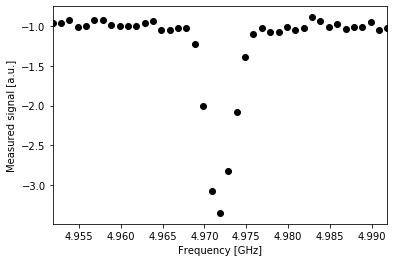

In [94]:
import matplotlib.pyplot as plt

sweep_values = []
sweep_values5 = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])
    sweep_values5.append(res[qubit])
sweep_values5 = np.real(sweep_values5)

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [95]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.972, 1, 5] # initial parameters for curve_fit
                                )

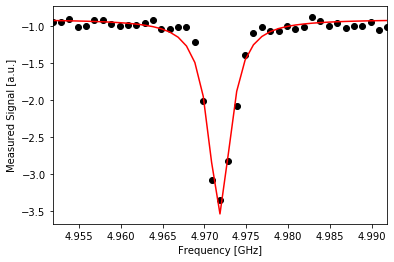

In [96]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [97]:
A, rough_qubit_frequency2, B, C = fit_params
rough_qubit_frequency1 = rough_qubit_frequency1*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency2, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97186 GHz to 4.97181 GHz.


In [98]:
fit_params5 = fit_params

In [99]:
fit_params

array([-1.29720976e-02,  4.97180773e+00,  1.57209146e-03, -9.14074696e-01])

In [100]:
fit_params1[1]

4.97180721713975

In [101]:
fit_params2[1]

4.971839052436073

In [102]:
fit_params3[1]

4.971891650918128

In [103]:
fit_params4[1]

4.971912583987321

In [104]:
fit_params5[1]

4.971807727137528

In [105]:
rough_mean_vals = np.mean([sweep_values1, sweep_values2, sweep_values3, sweep_values4, sweep_values5], axis=0)

In [107]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 rough_mean_vals, 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.972, 1, 5] # initial parameters for curve_fit
                                )

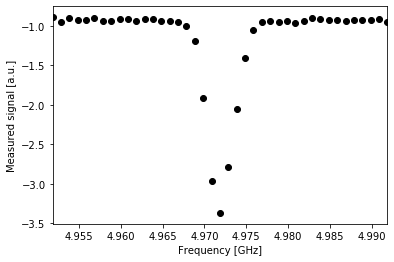

In [106]:
plt.scatter(frequencies_GHz, rough_mean_vals, color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

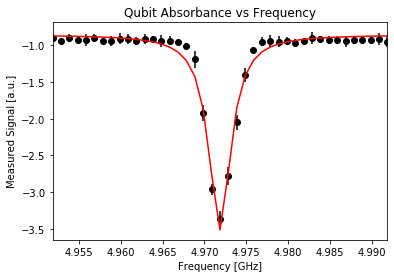

In [134]:
plt.scatter(frequencies_GHz, rough_mean_vals, color='black')

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")

arr = np.vstack((sweep_values1, sweep_values2, sweep_values3, sweep_values4, sweep_values5))

yerr = np.std(arr,axis=0)

plt.errorbar(frequencies_GHz, rough_mean_vals, yerr=yerr, color='black', ls = 'none')

plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.title("Qubit Absorbance vs Frequency")

plt.show()

In [126]:
avg_freq = fit_params[1]

In [127]:
#avg_freq = (fit_params1[1] + fit_params2[1] + fit_params3[1] + fit_params4[1] + fit_params5[1])/5

In [128]:
avg_freq

4.971848666925875

In [129]:
freq_std = np.sqrt(((fit_params1[1] - avg_freq)**2 + (fit_params2[1]-avg_freq)**2 + (fit_params3[1] - avg_freq)**2 + (fit_params4[1] - avg_freq)**2 + (fit_params5[1] - avg_freq)**2)/5)

In [130]:
freq_std

4.340415599402016e-05

In [ ]:
#rough qubit frequency is over. Take avg_freq and 

In [ ]:
#4.97184 +/- 0.00006 GHz

In [142]:
rough_qubit_frequency = avg_freq * GHz

In [143]:
rough_qubit_frequency

4971848666.925875

In [137]:
#90 and pi pulses!!!!!

In [138]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [139]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

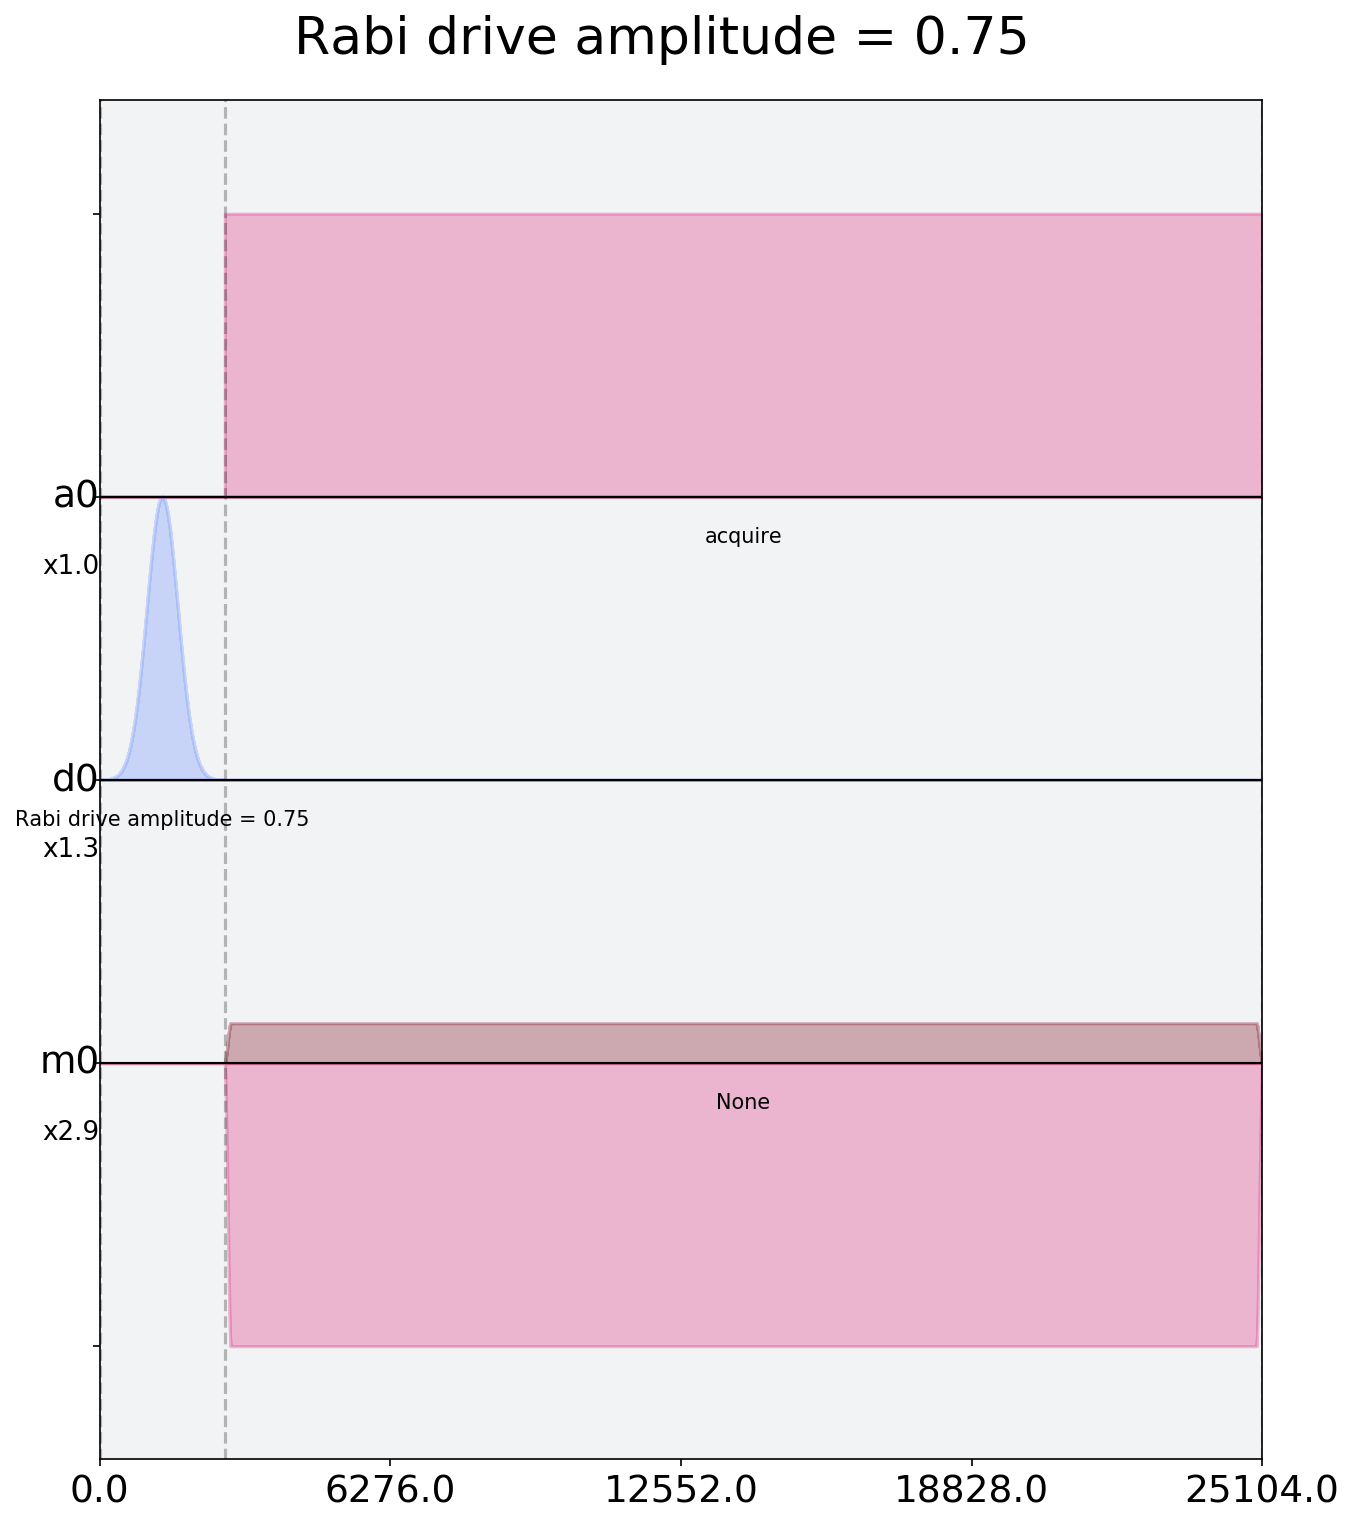

In [140]:
rabi_schedules[-1].draw(label=True)

In [144]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)

In [145]:
print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

6098f7e2eef9e1aeb418cf21
Job Status: job has successfully run


In [146]:
rabi_results1 = job.result(timeout=120)

In [147]:
print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

60990302c3a1cd8b9527287d
Job Status: job has successfully run


In [148]:
rabi_results2 = job.result(timeout=120)

In [149]:
print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

609905ff7ccc8bbb62281cf7
Job Status: job has successfully run


In [150]:
rabi_results3 = job.result(timeout=120)

In [151]:
print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

6099064a5411236b3a3f5375
Job Status: job has successfully run


In [152]:
rabi_results4 = job.result(timeout=120)

In [153]:
print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

6099069554112383f53f5377
Job Status: job has successfully run


In [154]:
rabi_results5 = job.result(timeout=120)

In [155]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

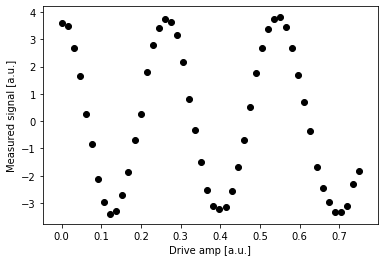

In [156]:
rabi_values1 = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values1.append(rabi_results1.get_memory(i)[qubit]*scale_factor)

rabi_values1 = np.real(baseline_remove(rabi_values1))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values1, color='black') # plot real part of Rabi values
plt.show()

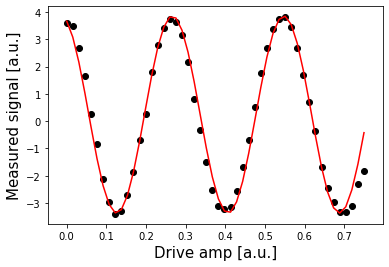

In [157]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values1, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.4, 0])

plt.scatter(drive_amps, rabi_values1, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation


plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [158]:
amp1 = abs(drive_period / 2)
print(f"Pi Amplitude = {amp1}")

Pi Amplitude = 0.14051706708510328


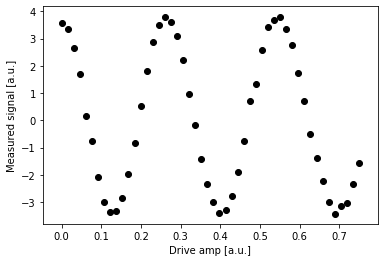

In [159]:
rabi_values2 = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values2.append(rabi_results2.get_memory(i)[qubit]*scale_factor)

rabi_values2 = np.real(baseline_remove(rabi_values2))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values2, color='black') # plot real part of Rabi values
plt.show()

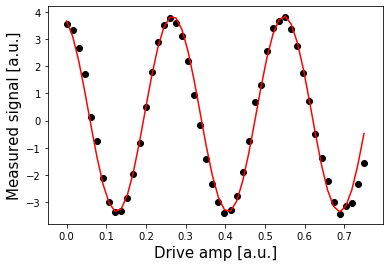

In [160]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values2, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.4, 0])

plt.scatter(drive_amps, rabi_values2, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation


plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [161]:
amp2 = abs(drive_period / 2)
print(f"Pi Amplitude = {amp2}")

Pi Amplitude = 0.14060554394695005


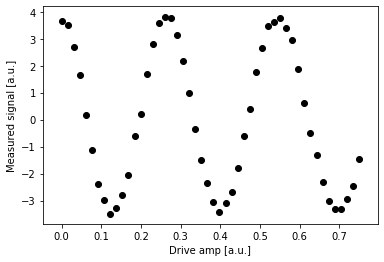

In [162]:
rabi_values3 = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values3.append(rabi_results3.get_memory(i)[qubit]*scale_factor)

rabi_values3 = np.real(baseline_remove(rabi_values3))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values3, color='black') # plot real part of Rabi values
plt.show()

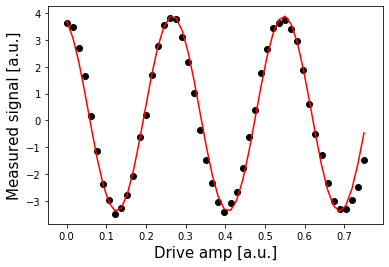

In [163]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values3, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.4, 0])

plt.scatter(drive_amps, rabi_values3, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation


plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [164]:
amp3 = abs(drive_period / 2)
print(f"Pi Amplitude = {amp3}")

Pi Amplitude = 0.14068012121747528


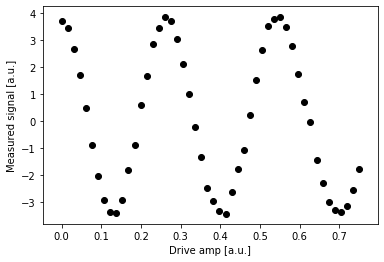

In [165]:
rabi_values4 = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values4.append(rabi_results4.get_memory(i)[qubit]*scale_factor)

rabi_values4 = np.real(baseline_remove(rabi_values4))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values4, color='black') # plot real part of Rabi values
plt.show()

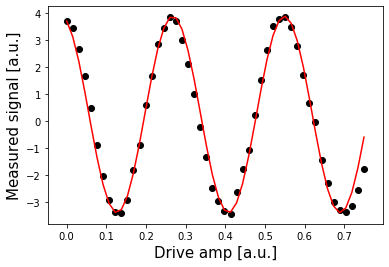

In [166]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values4, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.4, 0])

plt.scatter(drive_amps, rabi_values4, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation


plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [167]:
amp4 = abs(drive_period / 2)
print(f"Pi Amplitude = {amp4}")

Pi Amplitude = 0.14086619307222828


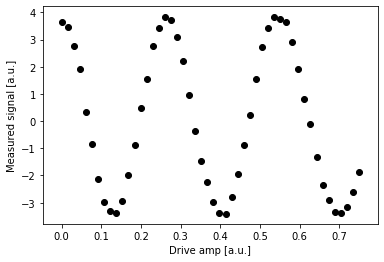

In [168]:
rabi_values5 = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values5.append(rabi_results5.get_memory(i)[qubit]*scale_factor)

rabi_values5 = np.real(baseline_remove(rabi_values5))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values5, color='black') # plot real part of Rabi values
plt.show()

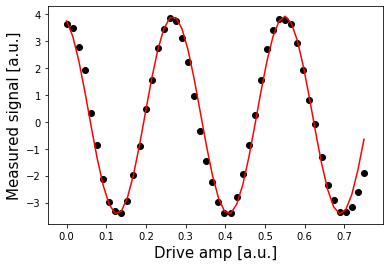

In [177]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values5, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.3, 0])

plt.scatter(drive_amps, rabi_values5, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation


plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [178]:
amp5 = abs(drive_period / 2)
print(f"Pi Amplitude = {amp5}")

Pi Amplitude = 0.14090025466819067


In [179]:
avg_amp = (amp1 + amp2 + amp3 + amp4 + amp5) / 5

In [180]:
avg_amp

0.1407138359979895

In [181]:
amp_std = np.sqrt(((amp1 - avg_amp)**2 + (amp2 - avg_amp)**2 + (amp3 - avg_amp)**2 + (amp4 - avg_amp)**2 + (amp5 - avg_amp)**2) / 5)

In [182]:
amp_std

0.00014801787627989575

In [183]:
rabi_values_mean = np.mean([rabi_values1, rabi_values2, rabi_values3, rabi_values4, rabi_values5], axis = 0)

In [184]:
rabi_stds = np.std([rabi_values1, rabi_values2, rabi_values3, rabi_values4, rabi_values5], axis = 0)

41
50


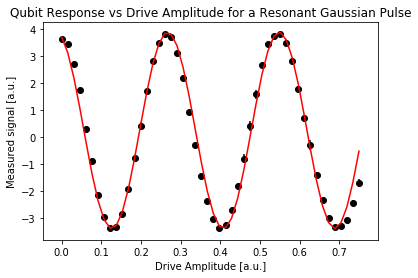

In [607]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values_mean, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.3, 0])

plt.xlabel("Drive Amplitude [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values_mean, color='black') # plot real part of Rabi values

print(len(frequencies_GHz))

print(len(rabi_values_mean))

yerr = [3] * len(drive_amps)

plt.errorbar(drive_amps, rabi_values_mean, yerr=rabi_stds, color = 'black', ls = 'none')

plt.plot(drive_amps, y_fit, color = 'red')

plt.title("Qubit Response vs Drive Amplitude for a Resonant Gaussian Pulse")

plt.show()

In [608]:
avg_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {amp5}")

Pi Amplitude = 0.14090025466819067


In [609]:
amp_std = np.sqrt(((amp1 - avg_amp)**2 + (amp2 - avg_amp)**2 + (amp3 - avg_amp)**2 + (amp4 - avg_amp)**2 + (amp5 - avg_amp)**2) / 5)

In [610]:
amp_std

0.0002380361575433018

In [201]:
#avg_amp = 0.14072 +/- (9 * 10^-5)

In [202]:
#avg_amp = 0.140720

In [203]:
#define pi pulse

In [204]:
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=avg_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')

In [205]:
x90_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=avg_amp / 2, 
                              sigma=drive_sigma,
                              name='x90_pulse')

In [206]:
#now we do a ramsey experiment to get a more precise qubit measurement

In [618]:
# Ramsey experiment parameters
time_max_us = 1.8
time_step_us = 0.025
times_us = np.arange(0.1, time_max_us, time_step_us)
# Convert to units of dt
delay_times_dt = times_us * us / dt

In [208]:
ramsey_schedules = []

for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"Ramsey delay = {delay * dt / us} us")
    this_schedule |= Play(x90_pulse, drive_chan)
    this_schedule |= Play(x90_pulse, drive_chan) << int(this_schedule.duration + delay)
    this_schedule |= measure << int(this_schedule.duration)

    ramsey_schedules.append(this_schedule)

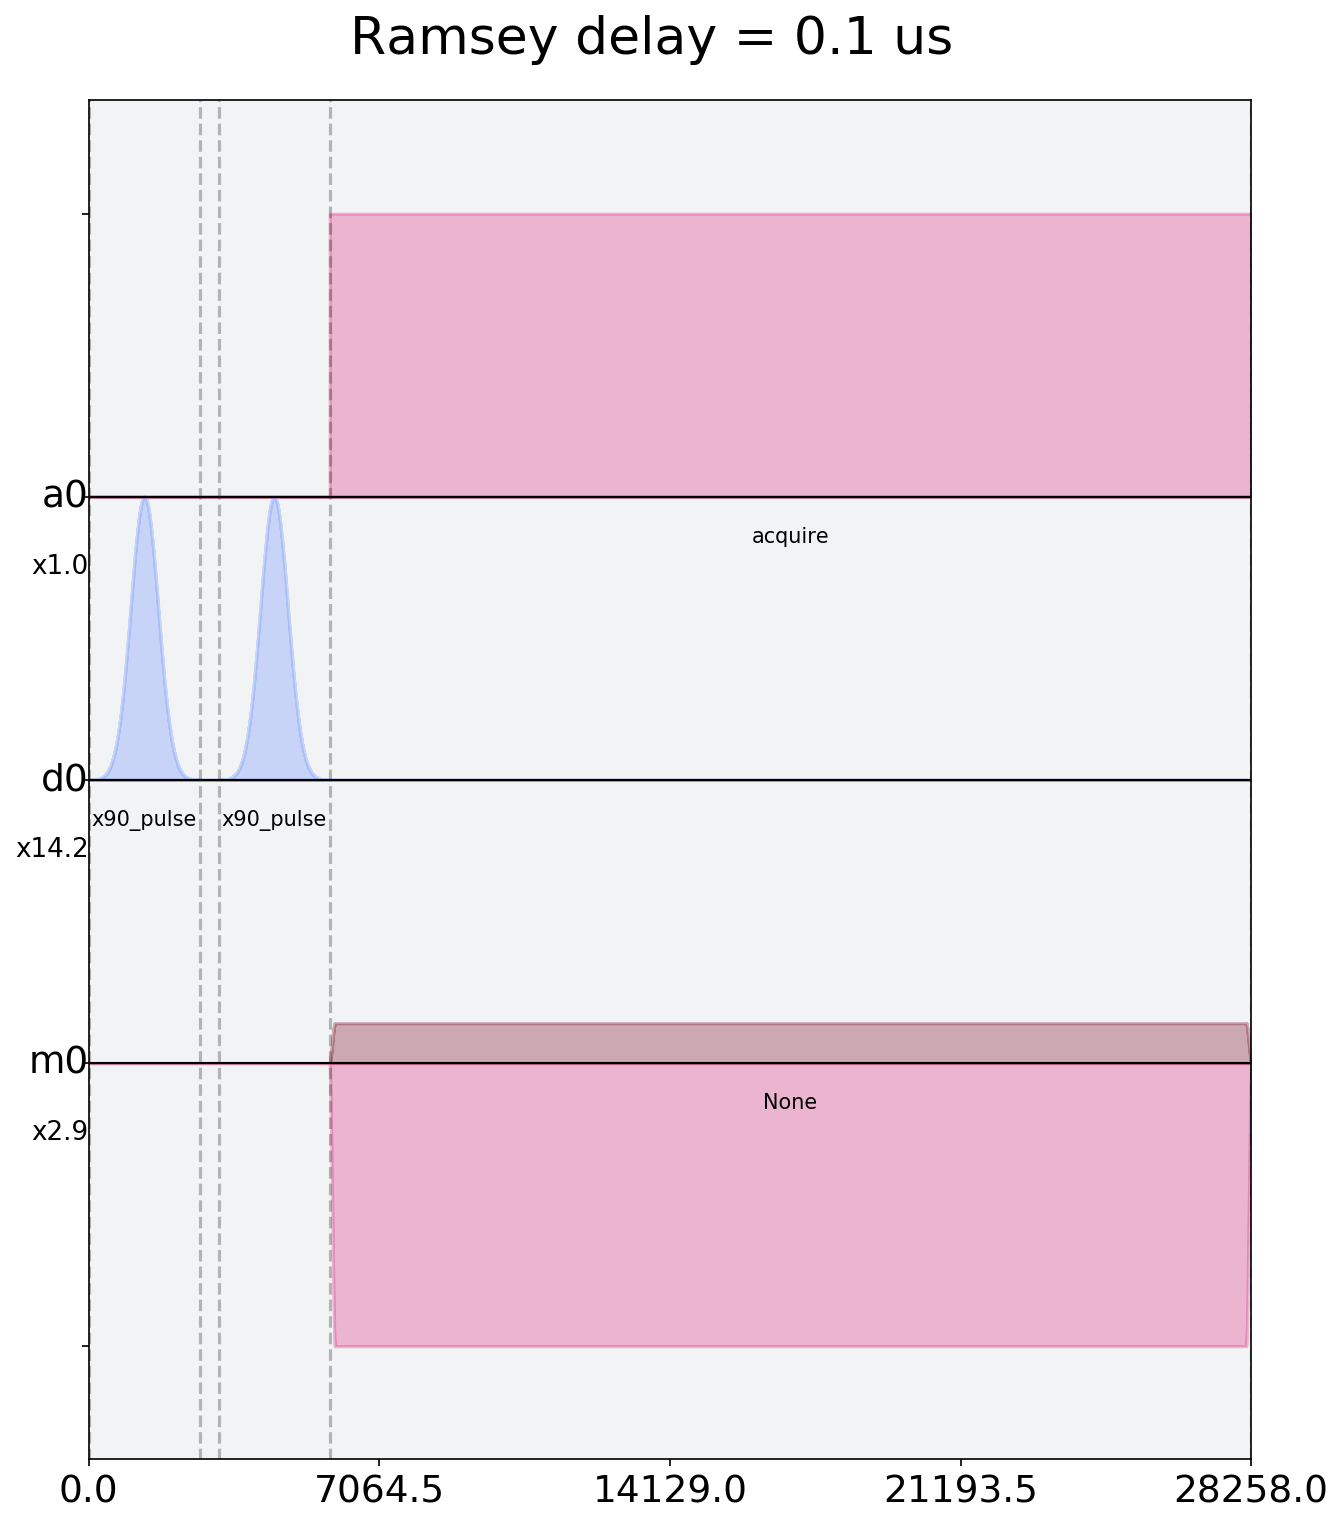

In [209]:
ramsey_schedules[0].draw(label=True)

In [210]:
# Execution settings
num_shots = 256

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz
ramsey_program = assemble(ramsey_schedules,
                             backend=backend,
                             meas_level=1,
                             meas_return='avg',
                             shots=num_shots,
                             schedule_los=[{drive_chan: ramsey_frequency}]*len(ramsey_schedules)
                            )

In [211]:
job1 = backend.run(ramsey_program)
# print(job.job_id())
job_monitor(job1)

Job Status: job has successfully run


In [212]:
job2 = backend.run(ramsey_program)
# print(job.job_id())
job_monitor(job2)

Job Status: job has successfully run


In [213]:
job3 = backend.run(ramsey_program)
# print(job.job_id())
job_monitor(job3)

Job Status: job has successfully run


In [214]:
job4 = backend.run(ramsey_program)
# print(job.job_id())
job_monitor(job4)

Job Status: job has successfully run


In [215]:
job5 = backend.run(ramsey_program)
# print(job.job_id())
job_monitor(job5)

Job Status: job has successfully run


In [216]:
ramsey_results1 = job1.result(timeout=120)

In [217]:
ramsey_results2 = job2.result(timeout=120)

In [218]:
ramsey_results3 = job3.result(timeout=120)

In [219]:
ramsey_results4 = job4.result(timeout=120)

In [220]:
ramsey_results5 = job5.result(timeout=120)

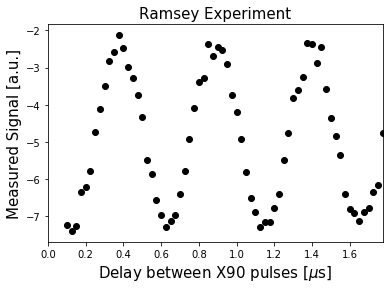

In [221]:
ramsey_values = []
for i in range(len(times_us)):
    ramsey_values.append(ramsey_results1.get_memory(i)[qubit]*scale_factor)

ramsey_values1 = ramsey_values
    
plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(times_us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

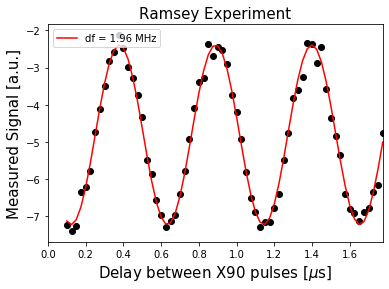

In [222]:
fit_params, y_fit = fit_function(times_us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 1./0.4, 0, 0.25]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.plot(times_us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(times_us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [223]:
ramsey_shift1 = del_f_MHz
ramsey_shift1

1.959572567610101

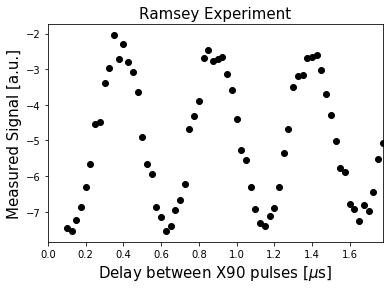

In [224]:
ramsey_values = []
for i in range(len(times_us)):
    ramsey_values.append(ramsey_results2.get_memory(i)[qubit]*scale_factor)
    
ramsey_values2 = ramsey_values
    
plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(times_us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

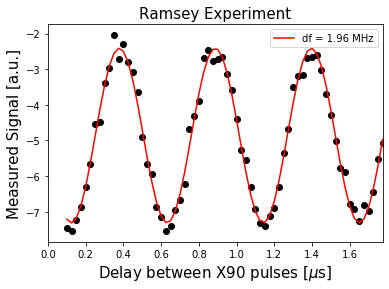

In [225]:
fit_params, y_fit = fit_function(times_us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 1./0.4, 0, 0.25]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.plot(times_us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(times_us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [226]:
ramsey_shift2 = del_f_MHz
ramsey_shift2

1.9638423216125036

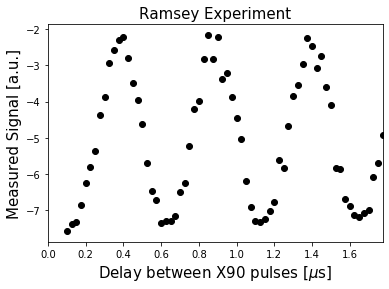

In [227]:
ramsey_values = []
for i in range(len(times_us)):
    ramsey_values.append(ramsey_results3.get_memory(i)[qubit]*scale_factor)
    
ramsey_values3 = ramsey_values
    
plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(times_us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

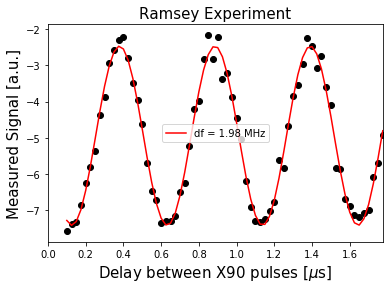

In [228]:
fit_params, y_fit = fit_function(times_us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 1./0.4, 0, 0.25]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.plot(times_us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(times_us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [229]:
ramsey_shift3 = del_f_MHz
ramsey_shift3

1.9770036017140786

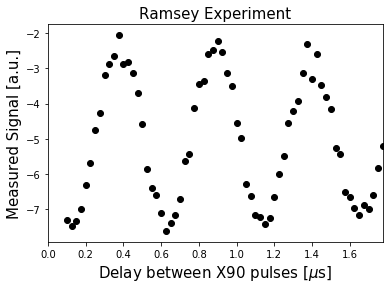

In [230]:
ramsey_values = []
for i in range(len(times_us)):
    ramsey_values.append(ramsey_results4.get_memory(i)[qubit]*scale_factor)
    
ramsey_values4 = ramsey_values
    
plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(times_us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

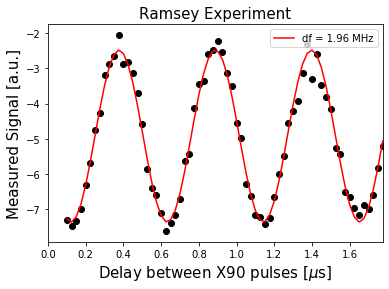

In [231]:
fit_params, y_fit = fit_function(times_us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 1./0.4, 0, 0.25]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.plot(times_us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(times_us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [232]:
ramsey_shift4 = del_f_MHz
ramsey_shift4

1.9603092498664338

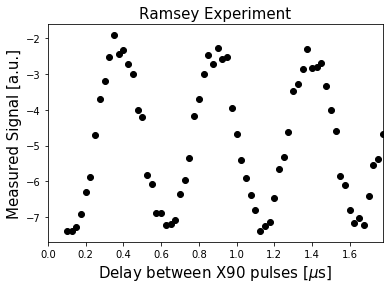

In [233]:
ramsey_values = []
for i in range(len(times_us)):
    ramsey_values.append(ramsey_results5.get_memory(i)[qubit]*scale_factor)
    
ramsey_values5 = ramsey_values
    
plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(times_us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

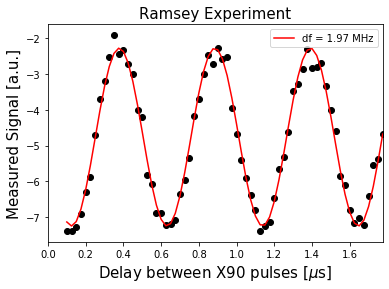

In [234]:
fit_params, y_fit = fit_function(times_us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 1./0.4, 0, 0.25]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.plot(times_us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(times_us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [235]:
ramsey_shift5 = del_f_MHz
ramsey_shift5

1.9722919222459898

In [288]:
#ramsey_shift_avg = (ramsey_shift1 + ramsey_shift2 + ramsey_shift3 + ramsey_shift4 + ramsey_shift5) / 5

In [464]:
#ramsey_shift_avg

1.97

In [612]:
ramsey_shift_means = np.mean([ramsey_values1, ramsey_values2, ramsey_values3, ramsey_values4, ramsey_values5], axis=0)

In [613]:
ramsey_shift_stds = np.std([ramsey_values1, ramsey_values2, ramsey_values3, ramsey_values4, ramsey_values5], axis=0)

68


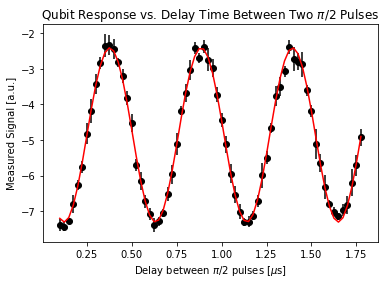

In [619]:
print(len(ramsey_shift_means))

fit_params, y_fit = fit_function(times_us, np.real(ramsey_shift_means),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 1./0.4, 0, 0.25]
                                )

plt.xlabel('Delay between $\pi / 2$ pulses [$\mu$s]')
plt.ylabel('Measured Signal [a.u.]')
plt.scatter(times_us, np.real(ramsey_shift_means), color='black') # plot real part of Rabi values


plt.errorbar(times_us, np.real(ramsey_shift_means), yerr=np.real(ramsey_shift_stds), color = 'black', ls = 'none')

plt.plot(times_us, y_fit, color = 'red')

plt.title("Qubit Response vs. Delay Time Between Two $\pi/2$ Pulses")

plt.show()

In [241]:
ramsey_shift_avg = del_f_MHz
ramsey_shift_avg

1.9722919222459898

In [242]:
ramsey_shift_std = np.sqrt(((ramsey_shift1 - ramsey_shift_avg)**2 + (ramsey_shift2 - ramsey_shift_avg)**2 + (ramsey_shift3 - ramsey_shift_avg)**2 + (ramsey_shift4 - ramsey_shift_avg)**2 + (ramsey_shift5 - ramsey_shift_avg)**2) / 5)

In [243]:
ramsey_shift_std

0.008932660230689397

In [ ]:
#avg_ramsey_shift = 1.970 +/- 0.003 (all MHz)

In [ ]:
#4.97184 +/- 0.00006 GHz is rough qubit

In [ ]:
#qubit_freq = 4.97381 +/- 0.000063 GHz

In [247]:
qubit_freq = rough_qubit_frequency + (ramsey_shift_avg - detuning_MHz) * MHz

In [248]:
qubit_freq

4971820958.848121

In [249]:
detuning_MHz

2

In [250]:
#Now we evaluate a 0-1 discriminator.

In [251]:
# Create two schedules

# Ground state schedule
gnd_schedule = pulse.Schedule(name="ground state")
gnd_schedule += measure

# Excited state schedule
exc_schedule = pulse.Schedule(name="excited state")
exc_schedule += Play(pi_pulse, drive_chan)  # We found this in Part 2A above
exc_schedule += measure << exc_schedule.duration

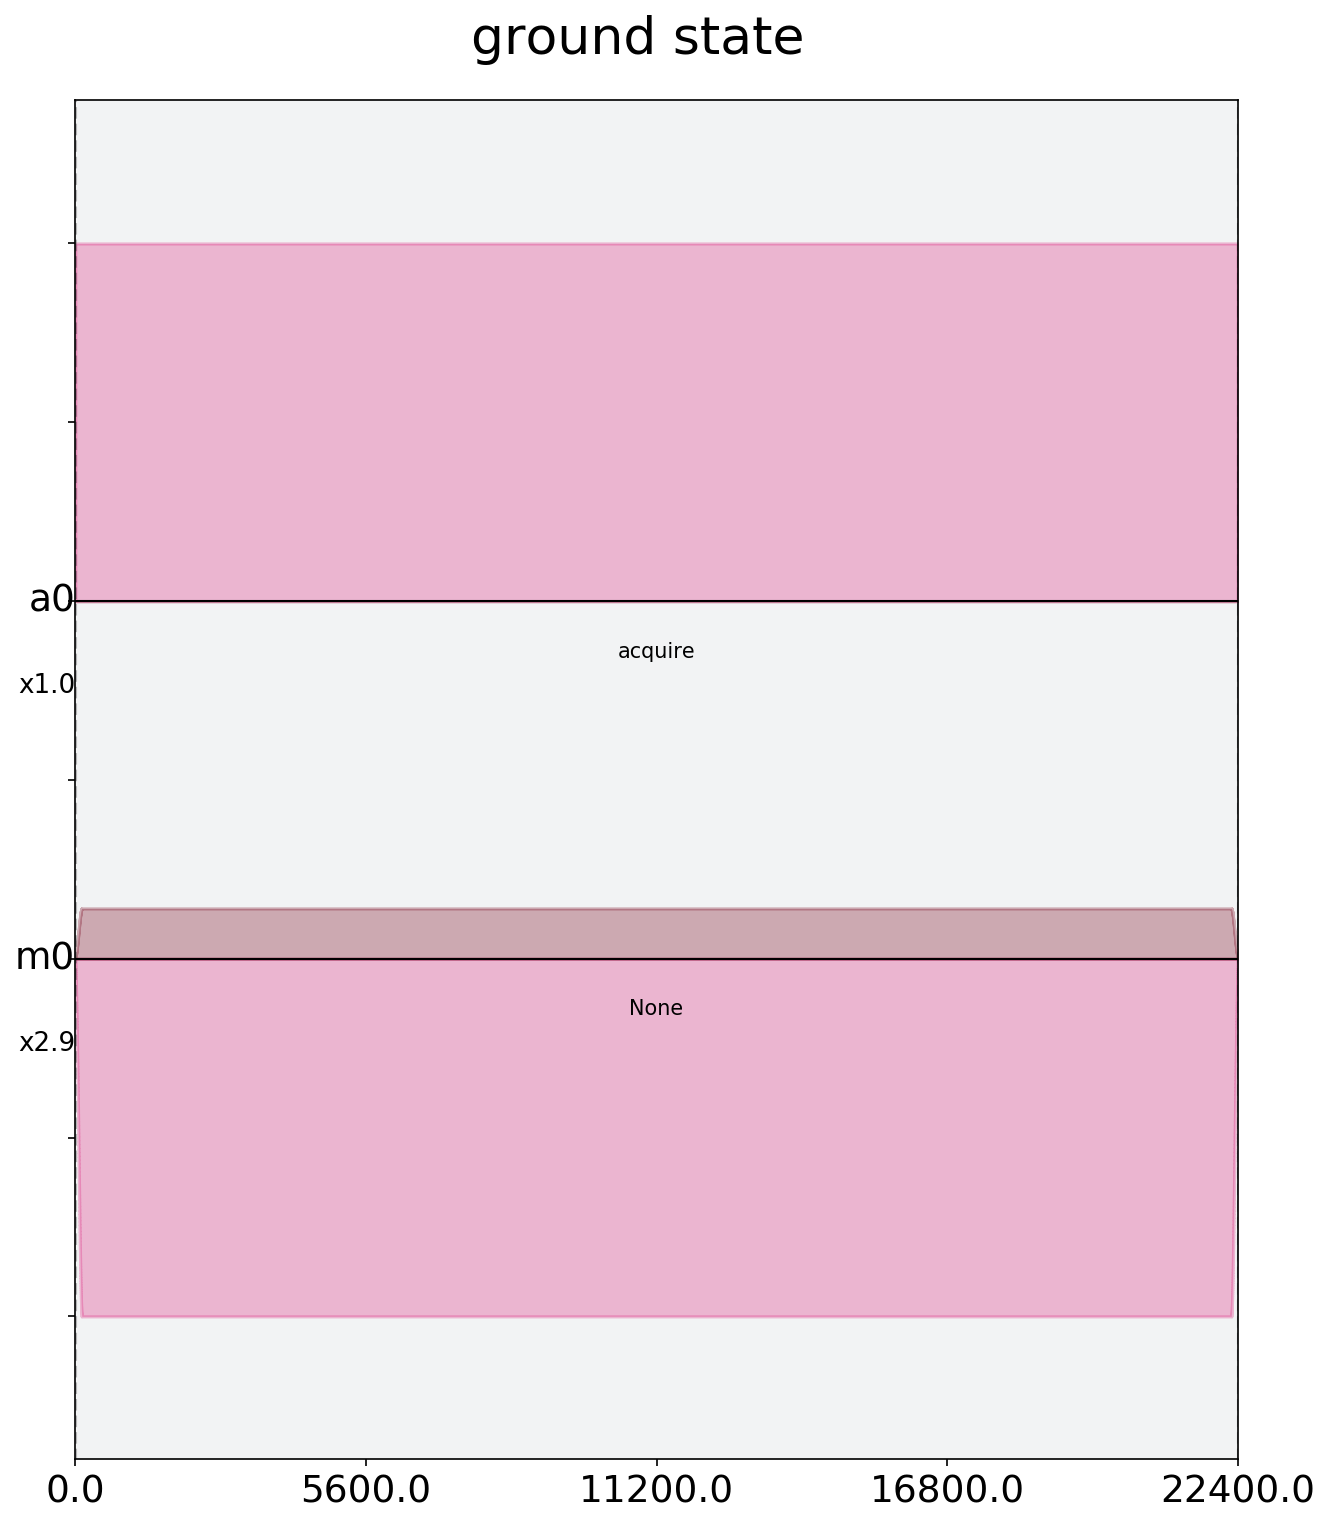

In [252]:
gnd_schedule.draw(label=True)

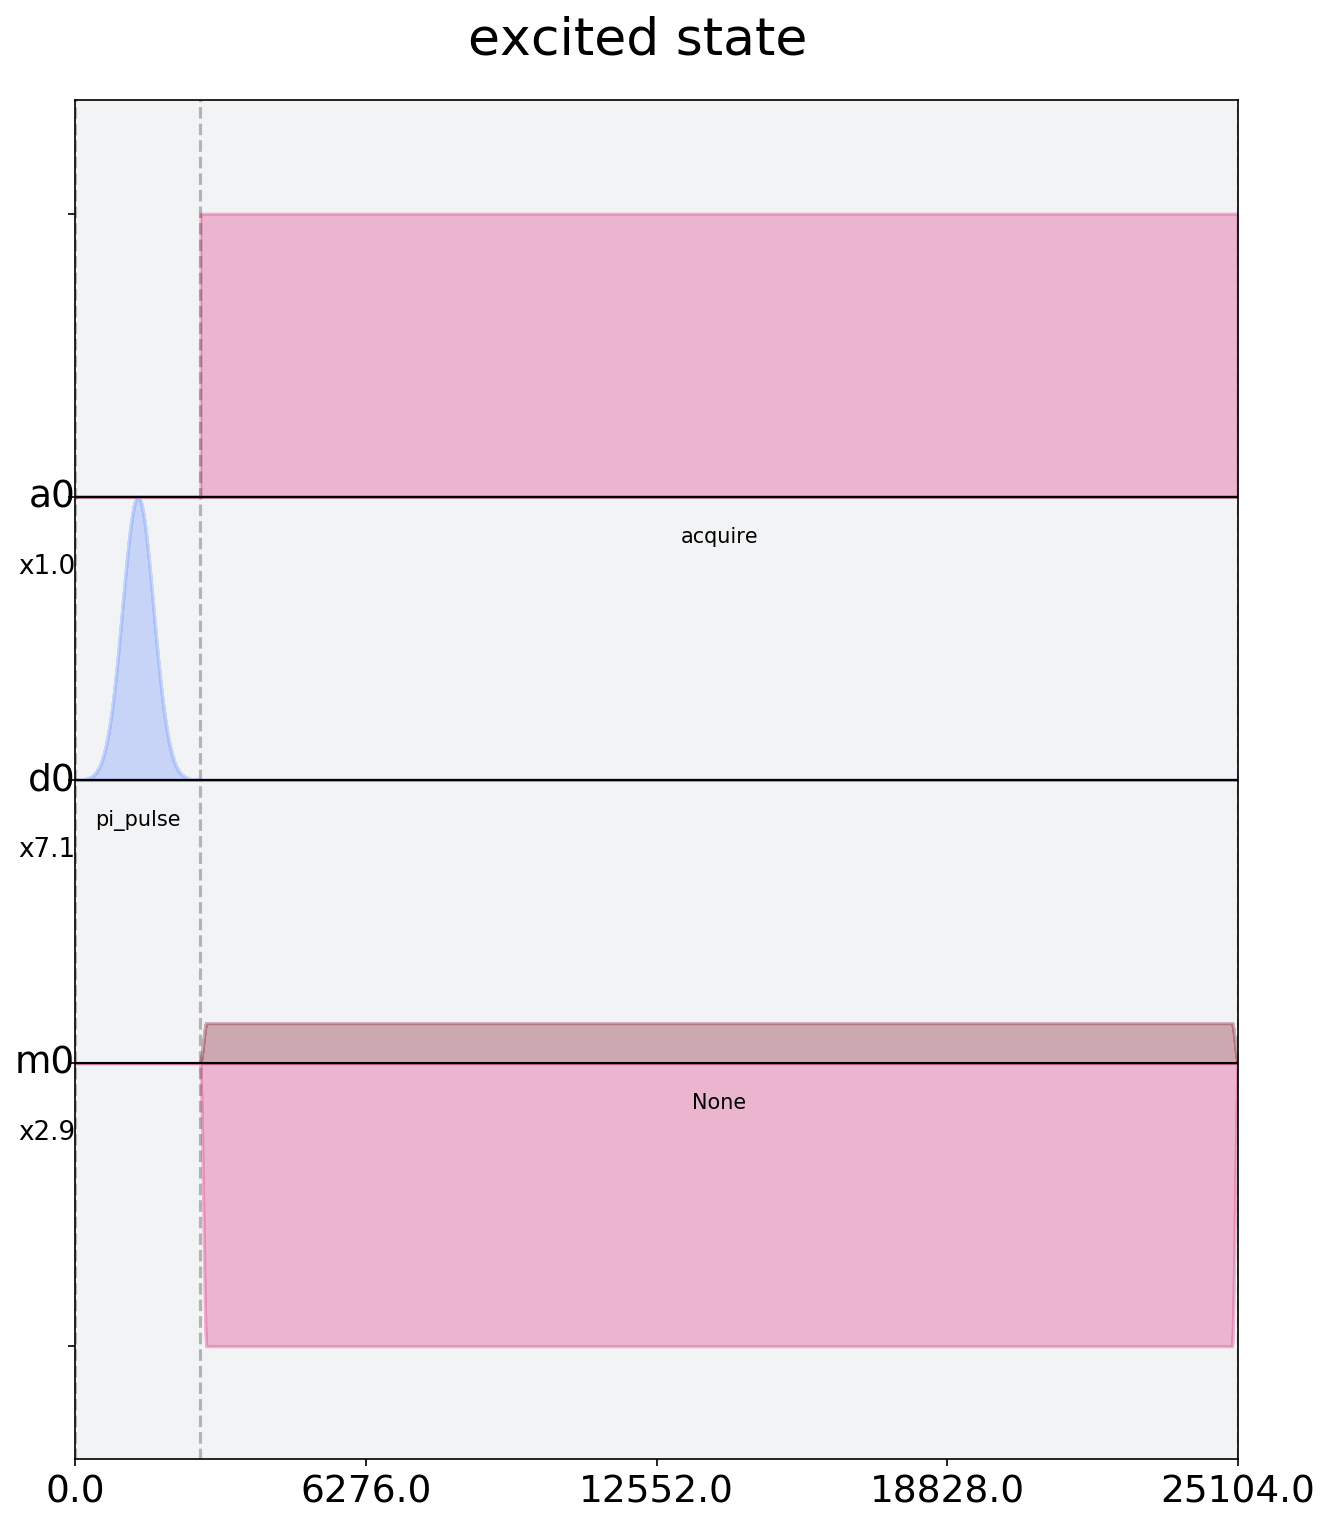

In [253]:
exc_schedule.draw(label=True)

In [254]:
# Execution settings
num_shots = 1024

gnd_exc_program = assemble([gnd_schedule, exc_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots,
                           schedule_los=[{drive_chan: qubit_freq}] * 2)

In [255]:
# print(job.job_id())
job = backend.run(gnd_exc_program)
job_monitor(job)

Job Status: job has successfully run


In [256]:
gnd_exc_results = job.result(timeout=120)

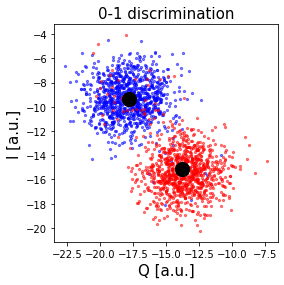

In [257]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

In [258]:
rough_qubit_frequency

4971848666.925875

In [259]:
#Now we evaluate the accuracy of our classifier.

In [260]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))

In [261]:
total_ground = 0
total_exc = 0
total = 0
for point in gnd_results:
    total += 1
    if classify(point) == 0:
        total_ground += 1
        
for point in exc_results:
    total += 1
    if classify(point) == 1:
        total_exc += 1

In [267]:
total_ground

1001

In [268]:
total_exc

971

In [269]:
total = total / 2

In [270]:
(total - (total_exc)) / total

0.0517578125

In [ ]:
#This corresponds to 5.17578125% infidelity.

In [271]:
#repeat 4 times, get T1, T2 times.

In [272]:
# T1 experiment parameters
time_max_us = 450
time_step_us = 6
times_us = np.arange(1, time_max_us, time_step_us)
# Convert to units of dt
delay_times_dt = times_us * us / dt
# We will use the same `pi_pulse` and qubit frequency that we calibrated and used before

In [273]:
# Create schedules for the experiment 
t1_schedules = []
for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
    this_schedule += Play(pi_pulse, drive_chan)
    this_schedule |= measure << int(delay)
    t1_schedules.append(this_schedule)

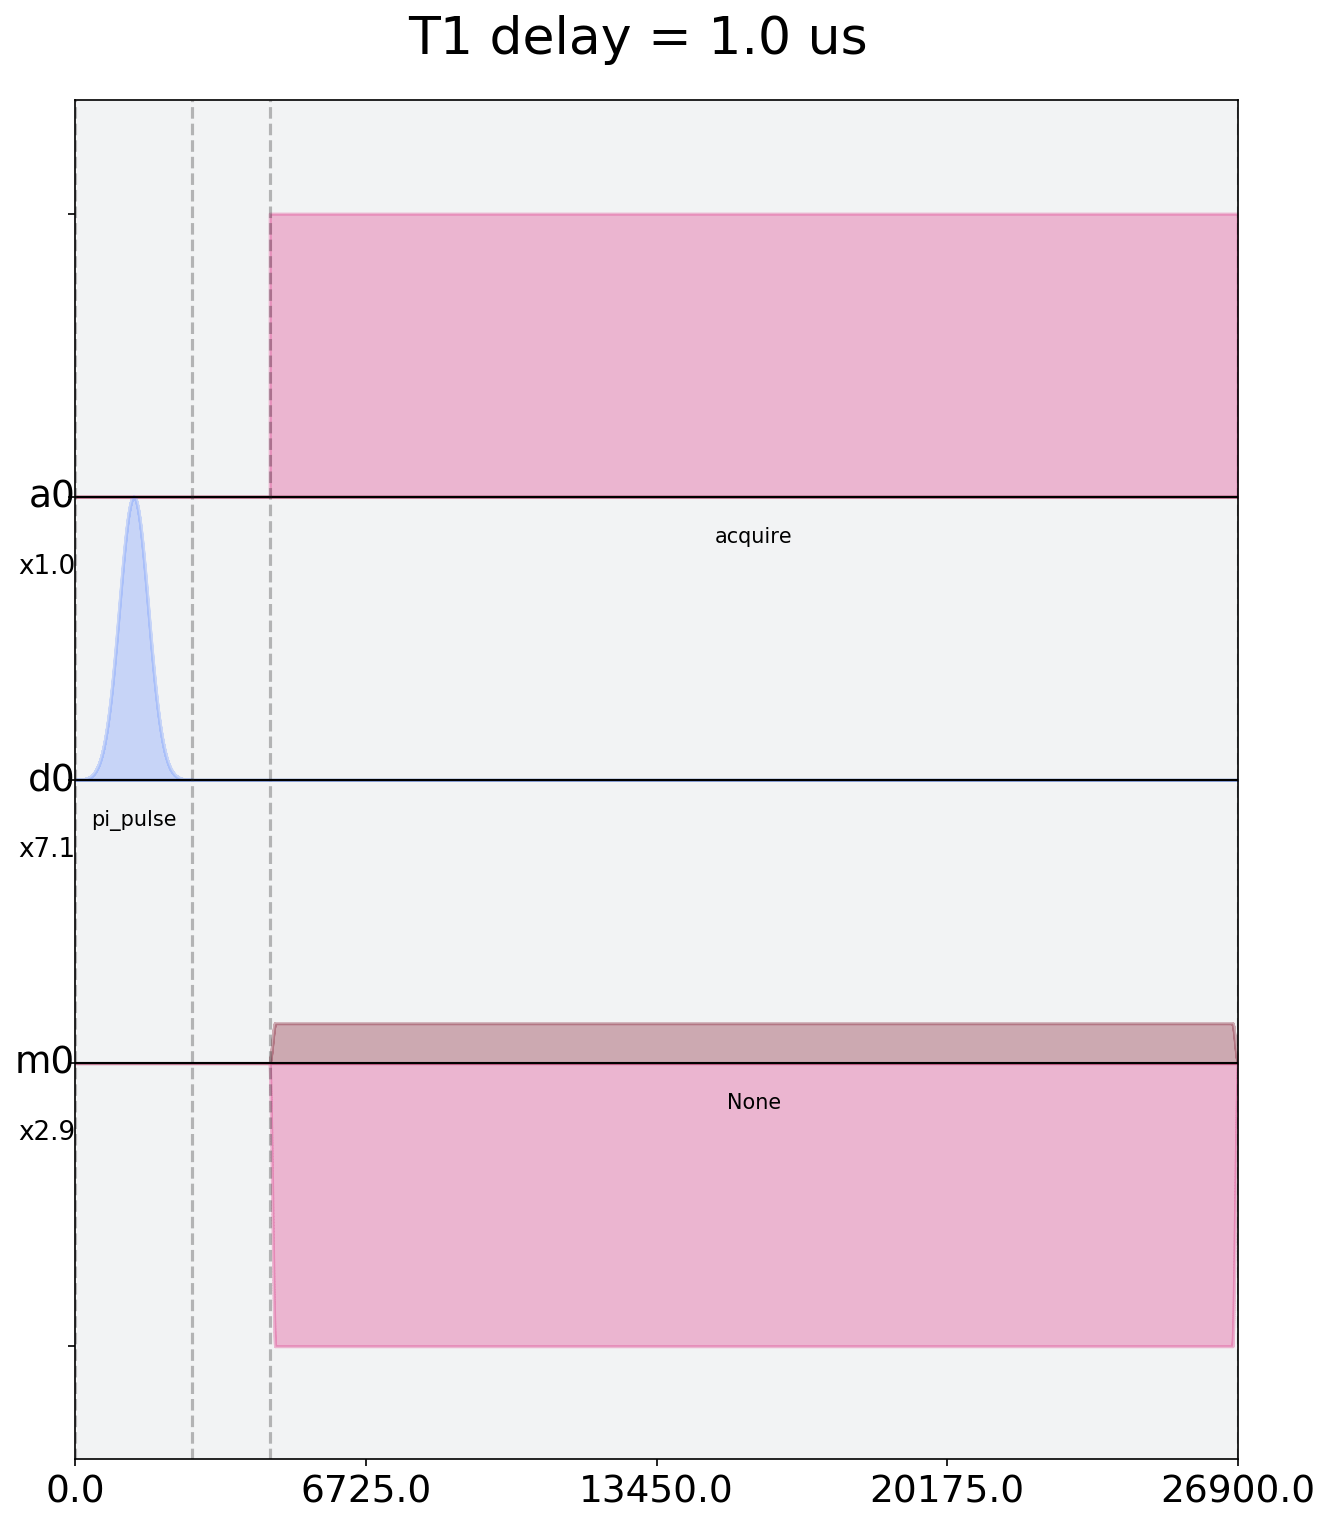

In [274]:
sched_idx = 0
t1_schedules[sched_idx].draw(label=True)

In [275]:
# Execution settings
num_shots = 256

t1_experiment = assemble(t1_schedules,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los=[{drive_chan: qubit_freq}] * len(t1_schedules))

In [276]:
job1 = backend.run(t1_experiment)
# print(job.job_id())
job_monitor(job)

Job Status: job has successfully run


In [277]:
t1_results1 = job1.result(timeout=120)

In [278]:
job2 = backend.run(t1_experiment)
# print(job.job_id())
job_monitor(job2)

Job Status: job has successfully run


In [279]:
t1_results2 = job2.result(timeout=120)

In [280]:
job3 = backend.run(t1_experiment)
# print(job.job_id())
job_monitor(job3)

Job Status: job has successfully run


In [281]:
t1_results3 = job3.result(timeout=120)

In [282]:
job4 = backend.run(t1_experiment)
# print(job.job_id())
job_monitor(job4)

Job Status: job has successfully run


In [283]:
t1_results4 = job4.result(timeout=120)

In [284]:
job5 = backend.run(t1_experiment)
# print(job.job_id())
job_monitor(job5)

Job Status: job has successfully run


In [285]:
t1_results5 = job5.result(timeout=120)

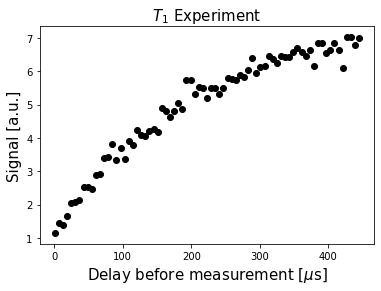

In [375]:
t1_values = []
for i in range(len(times_us)):
    t1_values.append(t1_results1.get_memory(i)[qubit]*scale_factor)
t1_values = np.real(t1_values)

t1_values1 = t1_values

plt.scatter(times_us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

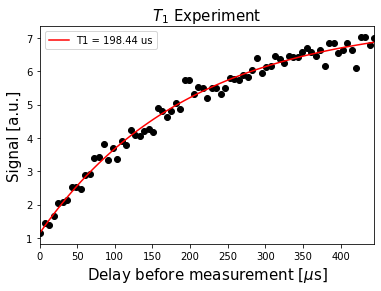

In [376]:
# Fit the data
fit_params, y_fit = fit_function(times_us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(times_us, t1_values, color='black')
plt.plot(times_us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

In [377]:
T1_1 = T1
T1_1

198.43842743713702

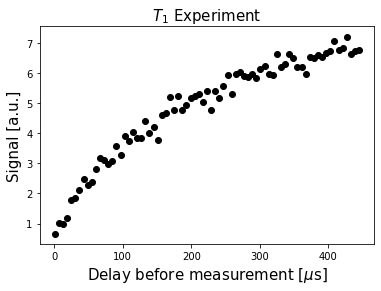

In [378]:
t1_values = []
for i in range(len(times_us)):
    t1_values.append(t1_results2.get_memory(i)[qubit]*scale_factor)
t1_values = np.real(t1_values)

t1_values2 = t1_values

plt.scatter(times_us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

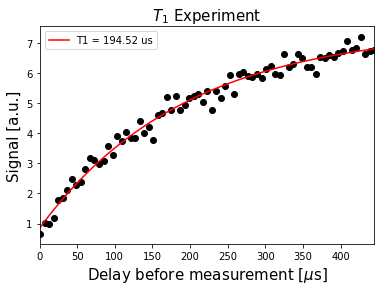

In [379]:
# Fit the data
fit_params, y_fit = fit_function(times_us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(times_us, t1_values, color='black')
plt.plot(times_us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

In [380]:
T1_2 = T1
T1_2

194.51856912108892

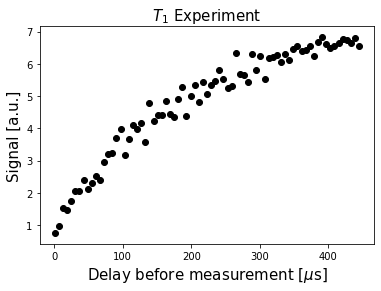

In [381]:
t1_values = []
for i in range(len(times_us)):
    t1_values.append(t1_results3.get_memory(i)[qubit]*scale_factor)
t1_values = np.real(t1_values)

t1_values3 = t1_values

plt.scatter(times_us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

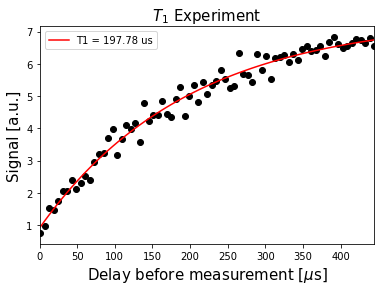

In [382]:
# Fit the data
fit_params, y_fit = fit_function(times_us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(times_us, t1_values, color='black')
plt.plot(times_us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

In [383]:
T1_3 = T1
T1_3

197.77725439208365

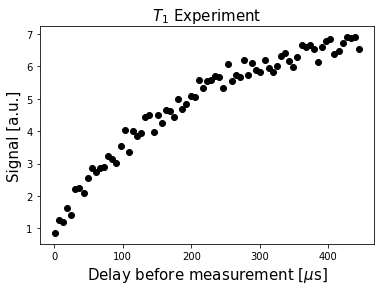

In [384]:
t1_values = []
for i in range(len(times_us)):
    t1_values.append(t1_results4.get_memory(i)[qubit]*scale_factor)
t1_values = np.real(t1_values)

t1_values4 = t1_values

plt.scatter(times_us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

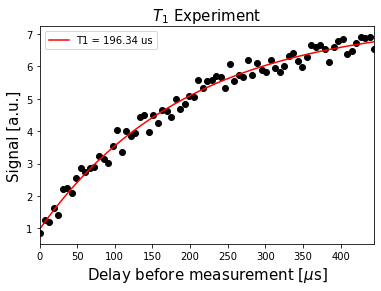

In [385]:
# Fit the data
fit_params, y_fit = fit_function(times_us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(times_us, t1_values, color='black')
plt.plot(times_us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

In [386]:
T1_4 = T1
T1_4

196.3370814736288

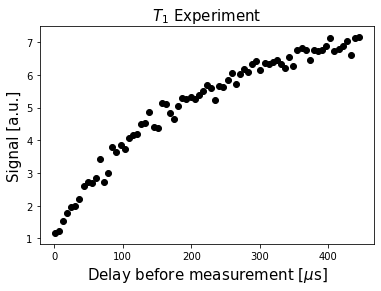

In [387]:
t1_values = []
for i in range(len(times_us)):
    t1_values.append(t1_results5.get_memory(i)[qubit]*scale_factor)
t1_values = np.real(t1_values)

t1_values5 = t1_values

plt.scatter(times_us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

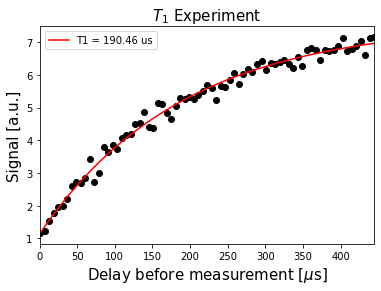

In [388]:
# Fit the data
fit_params, y_fit = fit_function(times_us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(times_us, t1_values, color='black')
plt.plot(times_us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

In [389]:
T1_5 = T1
T1_5

190.4615040121705

In [390]:
#avg_T1 = (T1_1 + T1_2 + T1_3 + T1_4 + T1_5) / 5
#avg_T1

195.5065672872218

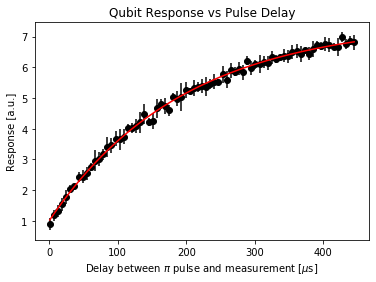

In [402]:
t1_vals_avg = np.mean([t1_values1, t1_values2, t1_values3, t1_values4, t1_values5], axis = 0)
t1_vals_std = np.std([t1_values1, t1_values2, t1_values3, t1_values4, t1_values5], axis = 0)

fit_params, y_fit = fit_function(times_us, t1_vals_avg, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(times_us, t1_vals_avg, color = 'black')
plt.errorbar(times_us, t1_vals_avg, yerr = t1_vals_std, color = 'black', ls = 'none')
plt.title("Qubit Response vs Pulse Delay")
plt.xlabel('Delay between $\pi$ pulse and measurement [$\mu$s]')
plt.ylabel('Response [a.u.]')
plt.plot(times_us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.show()

In [395]:
avg_T1 = T1

In [399]:
avg_T1

195.4857703500917

In [396]:
T1_std = np.sqrt(((T1_1 - avg_T1)**2 + (T1_2 - avg_T1) + (T1_3 - avg_T1)**2 + (T1_4 - avg_T1)**2 + (T1_5 - avg_T1)**2) / 5)

In [397]:
T1_std

2.7917687806409024

In [304]:
#avg T1 is 180.37 +/- 13.058 microseconds

In [305]:
#T2 experiment time!

In [306]:
# T2 experiment parameters
tau_max_us = 200
tau_step_us = 4
taus_us = np.arange(2, tau_max_us, tau_step_us)
# Convert to units of dt
delay_times_dt = taus_us * us / dt

# We will use the pi_pulse and x90_pulse from previous experiments

In [307]:
t2_schedules = []
for tau in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T2 delay = {tau *dt/us} us")
    this_schedule |= Play(x90_pulse, drive_chan)
    this_schedule |= Play(pi_pulse, drive_chan) << int(this_schedule.duration + tau)
    this_schedule |= Play(x90_pulse, drive_chan) << int(this_schedule.duration + tau)
    this_schedule |= measure << int(this_schedule.duration)
    
    t2_schedules.append(this_schedule)

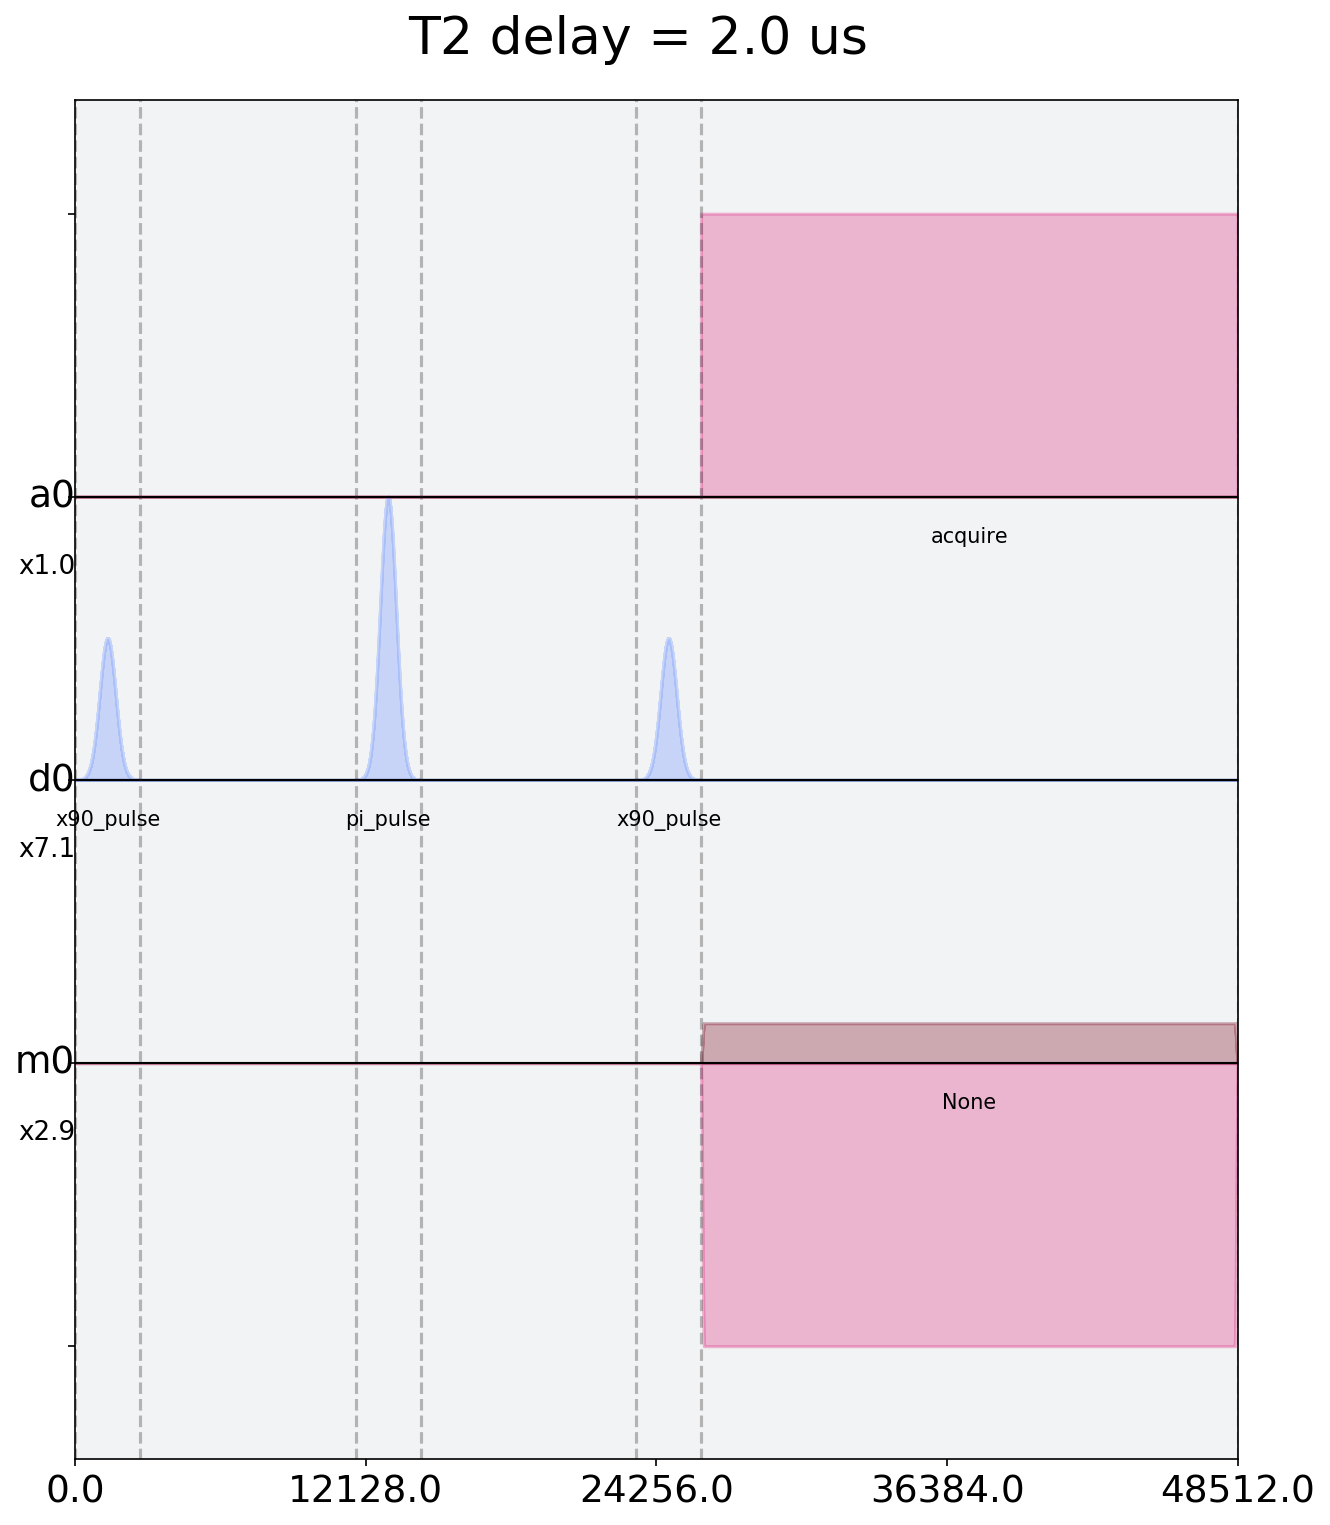

In [308]:
t2_schedules[0].draw(label=True)

In [309]:
# Execution settings
num_shots_per_point = 512

t2_experiment = assemble(t2_schedules,
                         backend=backend,
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots_per_point,
                         schedule_los=[{drive_chan: qubit_freq}]
                                      * len(t2_schedules))

In [310]:
job1 = backend.run(t2_experiment)
# print(job.job_id())
job_monitor(job1)

Job Status: job has successfully run


In [311]:
t2_results1 = job1.result(timeout=120)

In [312]:
job2 = backend.run(t2_experiment)
# print(job.job_id())
job_monitor(job2)

Job Status: job has successfully run


In [313]:
t2_results2 = job2.result(timeout=120)

In [314]:
job3 = backend.run(t2_experiment)
# print(job.job_id())
job_monitor(job3)

Job Status: job has successfully run


In [315]:
t2_results3 = job3.result(timeout=120)

In [316]:
job4 = backend.run(t2_experiment)
# print(job.job_id())
job_monitor(job4)

Job Status: job has successfully run


In [317]:
t2_results4 = job4.result(timeout=120)

In [318]:
job5 = backend.run(t2_experiment)
# print(job.job_id())
job_monitor(job5)

Job Status: job has successfully run


In [344]:
t2_results5 = job5.result(timeout=120)

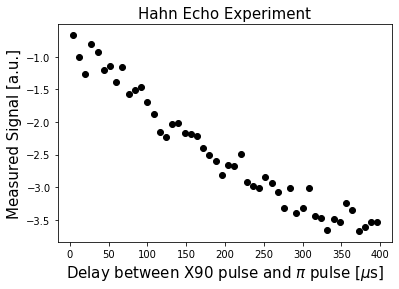

In [404]:
t2_values = []
for i in range(len(taus_us)):
    t2_values.append(t2_results1.get_memory(i)[qubit]*scale_factor)
    
t2_values1 = t2_values

plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

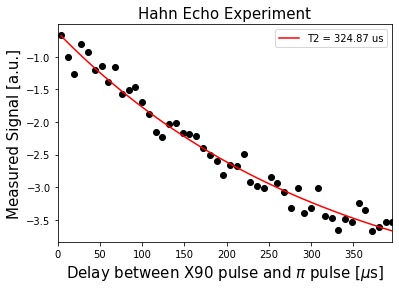

In [405]:
fit_params, y_fit = fit_function(2*taus_us, np.real(t2_values),
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 300])

_, _, T2 = fit_params
print()

plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.plot(2*taus_us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*taus_us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()


In [406]:
T2_1 = T2
T2_1

324.86919937044684

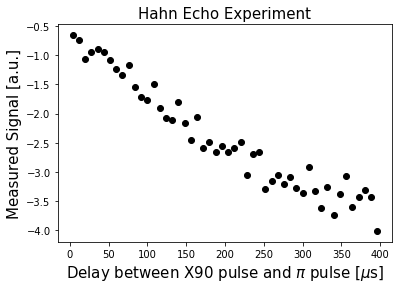

In [407]:
t2_values = []
for i in range(len(taus_us)):
    t2_values.append(t2_results2.get_memory(i)[qubit]*scale_factor)

t2_values2 = t2_values
    
plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

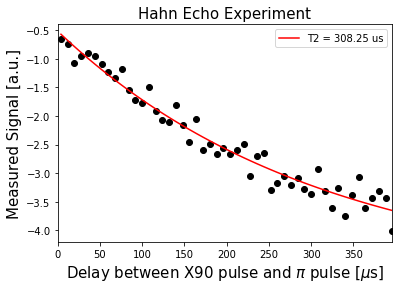

In [408]:
fit_params, y_fit = fit_function(2*taus_us, np.real(t2_values),
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 300])

_, _, T2 = fit_params
print()

plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.plot(2*taus_us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*taus_us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()

In [409]:
T2_2 = T2
T2_2

308.2546393836576

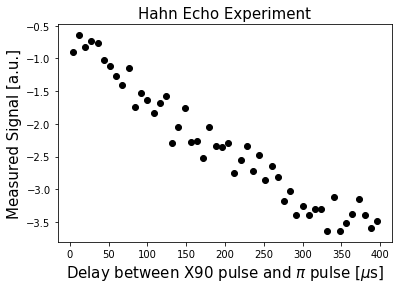

In [410]:
t2_values = []
for i in range(len(taus_us)):
    t2_values.append(t2_results3.get_memory(i)[qubit]*scale_factor)

t2_values3 = t2_values
    
plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

C:\Users\johnn\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


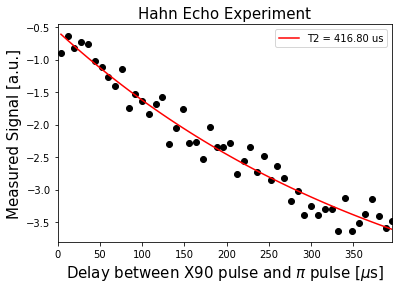

In [411]:
fit_params, y_fit = fit_function(2*taus_us, np.real(t2_values),
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_params
print()

plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.plot(2*taus_us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*taus_us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()

In [412]:
T2_3 = T2
T2_3

416.80474822479465

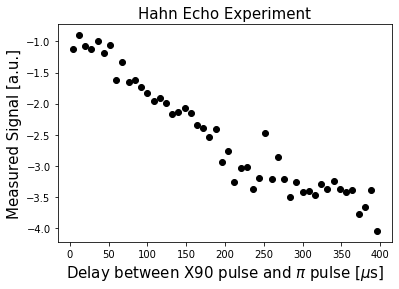

In [413]:
t2_values = []
for i in range(len(taus_us)):
    t2_values.append(t2_results4.get_memory(i)[qubit]*scale_factor)

t2_values4 = t2_values   

plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

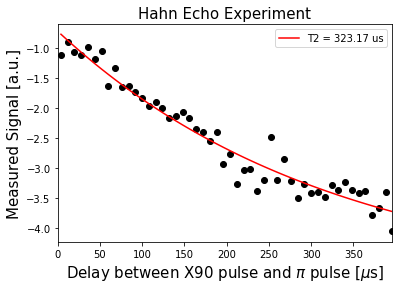

In [414]:
fit_params, y_fit = fit_function(2*taus_us, np.real(t2_values),
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_params
print()

plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.plot(2*taus_us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*taus_us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()

In [415]:
T2_4 = T2
T2_4

323.16515210907886

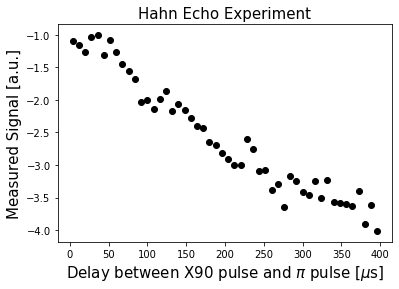

In [416]:
t2_values = []
for i in range(len(taus_us)):
    t2_values.append(t2_results5.get_memory(i)[qubit]*scale_factor)

t2_values5 = t2_values
    
plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

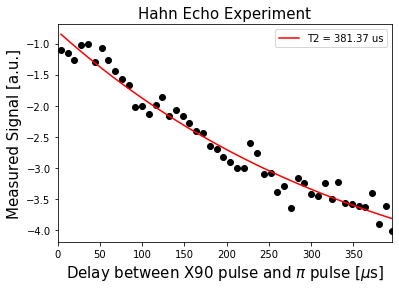

In [417]:
fit_params, y_fit = fit_function(2*taus_us, np.real(t2_values),
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_params
print()

plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.plot(2*taus_us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*taus_us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()

In [418]:
T2_5 = T2
T2_5

381.365005536713

In [419]:
#avg_T2 = (T2_1 + T2_2 + T2_3 + T2_4 + T2_5) / 5

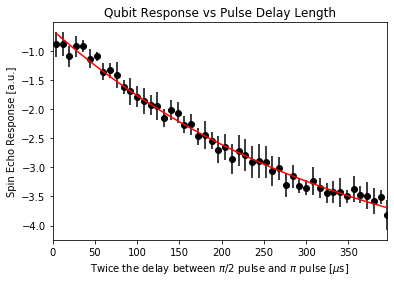

In [620]:
t2_values_avg = np.mean([t2_values1, t2_values2, t2_values3, t2_values4, t2_values5], axis = 0)
t2_values_std = np.std([t2_values1, t2_values2, t2_values3, t2_values4, t2_values5], axis = 0)

fit_params, y_fit = fit_function(2*taus_us, np.real(t2_values_avg),
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_params
print()

plt.scatter(2*taus_us, np.real(t2_values_avg), color='black')
plt.errorbar(2*taus_us, np.real(t2_values_avg), yerr = t2_values_std, color = 'black', ls = 'none')
plt.plot(2*taus_us, y_fit, color='red')
plt.xlim(0, np.max(2*taus_us))
plt.xlabel('Twice the delay between $\pi/2$ pulse and $\pi$ pulse [$\mu$s]')
plt.ylabel('Spin Echo Response [a.u.]')
plt.title('Qubit Response vs Pulse Delay Length')
plt.show()

In [578]:
T2

345.9772465453321

In [426]:
avg_T2 = T2

In [427]:
T2_std = np.sqrt(((T2_1 - avg_T2)**2 + (T2_2 - avg_T2)**2 + (T2_3 - avg_T2)**2 + (T2_4 - avg_T2)**2 + (T2_5 - avg_T2)**2) / 5)

In [428]:
avg_T2

345.9772465453321

In [429]:
T2_std

41.611933095606275

In [ ]:
#phasing time

In [600]:
avg_T2

345.9772465453321

In [601]:
rate = 1/(avg_T2*10**-6) - 1/(2*avg_T1*10**-6)

In [602]:
rate

332.6325609746773

In [603]:
1/rate

0.00300632023837296

In [437]:
T_phi = 1/rate

In [438]:
T_phi

3006.3202383729617

In [ ]:
#T_phi is in microseconds

In [441]:
#Now we do Cavity QED

In [442]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.visualization import SchedStyle
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

ibmqfactory.load_account:WARNING:2021-05-10 08:20:37,124: Credentials are already in use. The existing account in the session will be replaced.


In [443]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend.configuration().parametric_pulses = []  # Will allow us to send a larger waveform for our experiments
style = SchedStyle(figsize=(3, 2), title_font_size=10, axis_font_size=8) # style for displaying the pulse sequence

In [444]:
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# samples need to be multiples of 16 to accommodate the hardware limitations
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# process the reflective measurement results
# in a reflective measurement the data is encoded in the phase of the output signal
def process_reflective_measurement(freqs,values):
    phase_grad = np.gradient(savgol_filter(np.unwrap(np.angle(values)),3,2),freqs)
    return (phase_grad-min(phase_grad))/(max(phase_grad)-min(phase_grad)) - 1

# lorentzian function
def lorentzian(f, f0, k, a, offs):
    return -a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

#fit_lorentzian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the lorentzian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_lorentzian(freqs,values):
    p0=[freqs[np.argmin(values)],(freqs[-1]-freqs[0])/2,min(values),0]
    bounds=([freqs[0],0,-np.inf,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# exponential function
def exponential(t,tau,a,offset):
    return a*np.exp(-t/tau)+offset

# fit an exponential function
def fit_exponential(ts,values):
    p0=[np.average(ts),1,0]
    return curve_fit(exponential, ts, values,p0=p0)

In [445]:
#We measure kappa

In [446]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play, Acquire
import qiskit.pulse.library as pulse_lib
import numpy as np

dt=backend_config.dt   # hardware resolution

qubit=0   # qubit used in our experiment

readout_time = 4e-6
readout_sigma = 10e-9 

# low power drive for the resonator for dispersive readout
# We use a square pulse with a Guassian rise and fall time
readout_drive_low_power=pulse_lib.GaussianSquare(duration = get_closest_multiple_of_16(readout_time//dt),
                             amp = .3,
                             sigma = get_closest_multiple_of_16(readout_sigma//dt),
                             width = get_closest_multiple_of_16((readout_time-8*readout_sigma)//dt),
                             name = 'low power readout tone')

meas_chan = pulse.MeasureChannel(qubit) # resonator channel
acq_chan = pulse.AcquireChannel(qubit)  # readout signal acquisition channel

# readout output signal acquisition setup
acquisition_time = readout_time   # We want to acquire the readout signal for the full duration of the readout

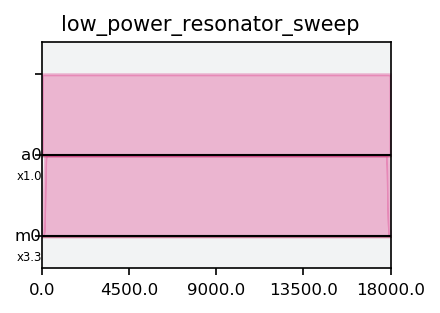

In [447]:
# build the pulse sequence for low power resonator spectroscopy
with pulse.build(name='low_power_resonator_sweep') as pulse_low_power:
    #drive the resonator with low power
    pulse.play(readout_drive_low_power, meas_chan) 
    #acquire the readout signal
    pulse.acquire(duration = get_closest_multiple_of_16(acquisition_time//dt),
                    qubit_or_channel = acq_chan,
                    register = pulse.MemorySlot(0))
    
pulse_low_power.draw(style=style)

In [448]:
center_freq = 6995775000.0  # an estimate for the resonator frequency
freq_span = 1e6 # resonator scan span. The span should be larger than the resonator linewidth kappa

frequencies_range = np.linspace(center_freq-freq_span/2,center_freq+freq_span/2,41)
# list of resonator frequencies for the experiment
schedule_frequencies = [{meas_chan: freq} for freq in frequencies_range] 

In [449]:
from qiskit import assemble
from qiskit.tools.monitor import job_monitor

num_shots_per_frequency = 8*1024 
frequency_sweep_low_power = assemble(pulse_low_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_low_power = backend.run(frequency_sweep_low_power)
job_monitor(job_low_power)

low_power_sweep_results1 = job_low_power.result(timeout=120)

Job Status: job has successfully run


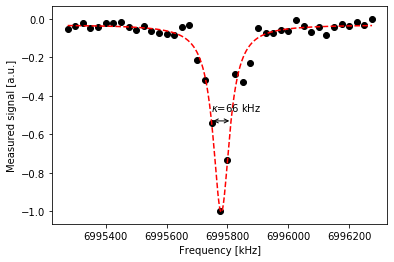

In [450]:
import matplotlib.pyplot as plt

low_power_sweep_values = []
for i in range(len(low_power_sweep_results1.results)):
    res_low_power = low_power_sweep_results1.get_memory(i)
    low_power_sweep_values.append(res_low_power[qubit])

low_power_sweep_values1 = process_reflective_measurement(frequencies_range,low_power_sweep_values)

plt.scatter(frequencies_range/1e3, low_power_sweep_values1, color='black')

popt_low_power1,_=fit_lorentzian(frequencies_range,low_power_sweep_values1)

popt_low_power1,_=fit_lorentzian(frequencies_range,low_power_sweep_values1)
f0, kappa, a, offset = popt_low_power1

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power1), color='red', ls='--')
plt.annotate("", xy=((f0-kappa/2)/1e3, offset-1/2), xytext=((f0+kappa/2)/1e3, offset-1/2), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\kappa$={:d} kHz".format(int(kappa/1e3)), xy=((f0-kappa/2)/1e3, offset-.45), color='black')

plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [451]:
kappa_1 = kappa
kappa_1 #in Hertz

66049.6307742988

In [452]:
center_freq = 6995775000.0  # an estimate for the resonator frequency
freq_span = 1e6 # resonator scan span. The span should be larger than the resonator linewidth kappa

frequencies_range = np.linspace(center_freq-freq_span/2,center_freq+freq_span/2,41)
# list of resonator frequencies for the experiment
schedule_frequencies = [{meas_chan: freq} for freq in frequencies_range] 

In [453]:
num_shots_per_frequency = 8*1024 
frequency_sweep_low_power = assemble(pulse_low_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_low_power = backend.run(frequency_sweep_low_power)
job_monitor(job_low_power)

low_power_sweep_results2 = job_low_power.result(timeout=120)

Job Status: job has successfully run


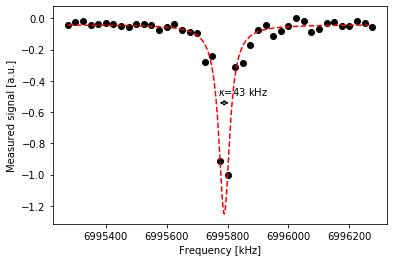

In [454]:
import matplotlib.pyplot as plt

low_power_sweep_values = []
for i in range(len(low_power_sweep_results2.results)):
    res_low_power = low_power_sweep_results2.get_memory(i)
    low_power_sweep_values.append(res_low_power[qubit])

low_power_sweep_values2 = process_reflective_measurement(frequencies_range,low_power_sweep_values)

plt.scatter(frequencies_range/1e3, low_power_sweep_values2, color='black')

popt_low_power2,_=fit_lorentzian(frequencies_range,low_power_sweep_values2)

popt_low_power2,_=fit_lorentzian(frequencies_range,low_power_sweep_values2)
f0, kappa, a, offset = popt_low_power2

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power2), color='red', ls='--')
plt.annotate("", xy=((f0-kappa/2)/1e3, offset-1/2), xytext=((f0+kappa/2)/1e3, offset-1/2), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\kappa$={:d} kHz".format(int(kappa/1e3)), xy=((f0-kappa/2)/1e3, offset-.45), color='black')

plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [455]:
kappa_2 = kappa
kappa_2

43328.47816938712

In [456]:
center_freq = 6995775000.0  # an estimate for the resonator frequency
freq_span = 1e6 # resonator scan span. The span should be larger than the resonator linewidth kappa

frequencies_range = np.linspace(center_freq-freq_span/2,center_freq+freq_span/2,41)
# list of resonator frequencies for the experiment
schedule_frequencies = [{meas_chan: freq} for freq in frequencies_range] 

In [457]:
num_shots_per_frequency = 8*1024 
frequency_sweep_low_power = assemble(pulse_low_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_low_power = backend.run(frequency_sweep_low_power)
job_monitor(job_low_power)

low_power_sweep_results3 = job_low_power.result(timeout=120)

Job Status: job has successfully run


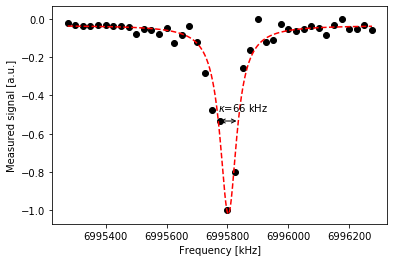

In [458]:
import matplotlib.pyplot as plt

low_power_sweep_values = []
for i in range(len(low_power_sweep_results3.results)):
    res_low_power = low_power_sweep_results3.get_memory(i)
    low_power_sweep_values.append(res_low_power[qubit])

low_power_sweep_values3 = process_reflective_measurement(frequencies_range,low_power_sweep_values)

plt.scatter(frequencies_range/1e3, low_power_sweep_values3, color='black')

popt_low_power3,_=fit_lorentzian(frequencies_range,low_power_sweep_values3)

popt_low_power3,_=fit_lorentzian(frequencies_range,low_power_sweep_values3)
f0, kappa, a, offset = popt_low_power3

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power3), color='red', ls='--')
plt.annotate("", xy=((f0-kappa/2)/1e3, offset-1/2), xytext=((f0+kappa/2)/1e3, offset-1/2), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\kappa$={:d} kHz".format(int(kappa/1e3)), xy=((f0-kappa/2)/1e3, offset-.45), color='black')

plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [459]:
kappa_3 = kappa
kappa_3

66771.55099537665

In [460]:
center_freq = 6995775000.0  # an estimate for the resonator frequency
freq_span = 1e6 # resonator scan span. The span should be larger than the resonator linewidth kappa

frequencies_range = np.linspace(center_freq-freq_span/2,center_freq+freq_span/2,41)
# list of resonator frequencies for the experiment
schedule_frequencies = [{meas_chan: freq} for freq in frequencies_range] 

In [461]:
num_shots_per_frequency = 8*1024 
frequency_sweep_low_power = assemble(pulse_low_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_low_power = backend.run(frequency_sweep_low_power)
job_monitor(job_low_power)

low_power_sweep_results4 = job_low_power.result(timeout=120)

Job Status: job has successfully run


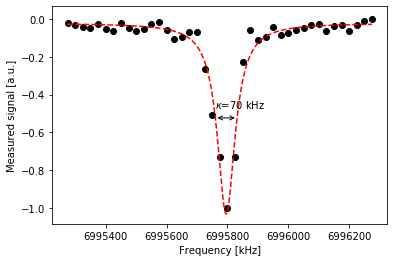

In [462]:
import matplotlib.pyplot as plt

low_power_sweep_values = []
for i in range(len(low_power_sweep_results4.results)):
    res_low_power = low_power_sweep_results4.get_memory(i)
    low_power_sweep_values.append(res_low_power[qubit])

low_power_sweep_values4 = process_reflective_measurement(frequencies_range,low_power_sweep_values)

plt.scatter(frequencies_range/1e3, low_power_sweep_values4, color='black')

popt_low_power4,_=fit_lorentzian(frequencies_range,low_power_sweep_values4)

popt_low_power4,_=fit_lorentzian(frequencies_range,low_power_sweep_values4)
f0, kappa, a, offset = popt_low_power4

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power4), color='red', ls='--')
plt.annotate("", xy=((f0-kappa/2)/1e3, offset-1/2), xytext=((f0+kappa/2)/1e3, offset-1/2), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\kappa$={:d} kHz".format(int(kappa/1e3)), xy=((f0-kappa/2)/1e3, offset-.45), color='black')

plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [463]:
kappa_4 = kappa
kappa_4

70993.80792606095

In [464]:
center_freq = 6995775000.0  # an estimate for the resonator frequency
freq_span = 1e6 # resonator scan span. The span should be larger than the resonator linewidth kappa

frequencies_range = np.linspace(center_freq-freq_span/2,center_freq+freq_span/2,41)
# list of resonator frequencies for the experiment
schedule_frequencies = [{meas_chan: freq} for freq in frequencies_range] 

In [465]:
num_shots_per_frequency = 8*1024 
frequency_sweep_low_power = assemble(pulse_low_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_low_power = backend.run(frequency_sweep_low_power)
job_monitor(job_low_power)

low_power_sweep_results5 = job_low_power.result(timeout=120)

Job Status: job has successfully run


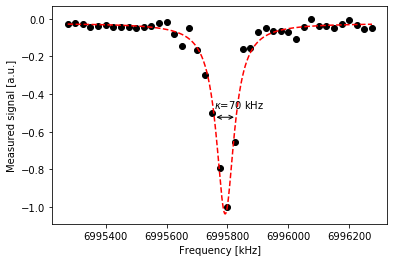

In [466]:
import matplotlib.pyplot as plt

low_power_sweep_values = []
for i in range(len(low_power_sweep_results5.results)):
    res_low_power = low_power_sweep_results5.get_memory(i)
    low_power_sweep_values.append(res_low_power[qubit])

low_power_sweep_values5 = process_reflective_measurement(frequencies_range,low_power_sweep_values)

plt.scatter(frequencies_range/1e3, low_power_sweep_values5, color='black')

popt_low_power5,_=fit_lorentzian(frequencies_range,low_power_sweep_values5)

popt_low_power5,_=fit_lorentzian(frequencies_range,low_power_sweep_values5)
f0, kappa, a, offset = popt_low_power5

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power5), color='red', ls='--')
plt.annotate("", xy=((f0-kappa/2)/1e3, offset-1/2), xytext=((f0+kappa/2)/1e3, offset-1/2), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\kappa$={:d} kHz".format(int(kappa/1e3)), xy=((f0-kappa/2)/1e3, offset-.45), color='black')

plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [467]:
kappa_5 = kappa
kappa_5

70789.04543473611

In [509]:
kappa_avgs = np.mean([low_power_sweep_values1, low_power_sweep_values2, low_power_sweep_values3, low_power_sweep_values4, low_power_sweep_values5], axis = 0)

In [510]:
kappa_stds =np.std([low_power_sweep_values1, low_power_sweep_values2, low_power_sweep_values3, low_power_sweep_values4, low_power_sweep_values5], axis = 0) 

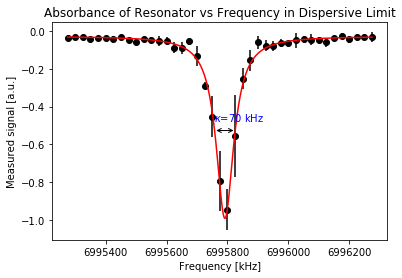

In [556]:
plt.scatter(frequencies_range/1e3, kappa_avgs, color='black')

popt_low_power,_=fit_lorentzian(frequencies_range,kappa_avgs)

popt_low_power,_=fit_lorentzian(frequencies_range,kappa_avgs)
f0, kappa, a, offset = popt_low_power

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power), color='red')
plt.annotate("", xy=((f0-kappa/2)/1e3, offset-1/2), xytext=((f0+kappa/2)/1e3, offset-1/2), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\kappa$={:d} kHz".format(int(kappa/1e3)), xy=((f0-kappa/2)/1e3, offset-.45), color='blue')
plt.errorbar(frequencies_range/1e3, kappa_avgs, yerr = kappa_stds, color = 'black', ls = 'none')

plt.title('Absorbance of Resonator vs Frequency in Dispersive Limit')

plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [527]:
avg_kappa = kappa

In [528]:
#avg_kappa = (kappa_1 + kappa_2 + kappa_3 + kappa_4 + kappa_5) / 5

In [529]:
kappa_std = np.sqrt(((kappa_1 - avg_kappa)**2 + (kappa_2 - avg_kappa)**2 + (kappa_3 - avg_kappa)**2 + (kappa_4 - avg_kappa)**2 + (kappa_5 - avg_kappa)**2)/ 5)

In [530]:
avg_kappa

70229.00276257984

In [531]:
kappa_std

12279.72248107142

In [473]:
#now chi and g

In [474]:
readout_drive_high_power=pulse_lib.GaussianSquare(duration = get_closest_multiple_of_16(readout_time//dt),
                             amp = 1, # High drive amplitude
                             sigma = get_closest_multiple_of_16(readout_sigma//dt),
                             width = get_closest_multiple_of_16((readout_time-8*readout_sigma)//dt),
                             name = 'high power readout tone')

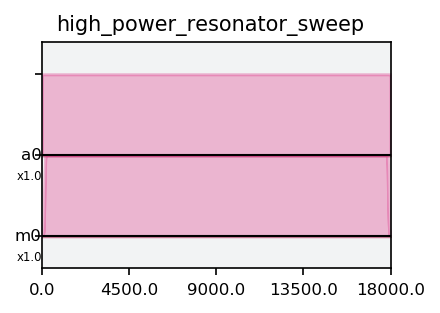

In [475]:
# build the pulse sequence for high power resonator spectroscopy
with pulse.build(name='high_power_resonator_sweep') as pulse_high_power:
    #drive the resonator with high power
    pulse.play(readout_drive_high_power, meas_chan)
    #acquire the readout signal
    pulse.acquire(duration = get_closest_multiple_of_16(acquisition_time//dt),
                    qubit_or_channel = acq_chan,
                    register = pulse.MemorySlot(0))
    
pulse_high_power.draw(style=style)

In [476]:
frequency_sweep_high_power = assemble(pulse_high_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_high_power = backend.run(frequency_sweep_high_power)
job_monitor(job_high_power)

high_power_sweep_results = job_high_power.result(timeout=120)

Job Status: job has successfully run


In [477]:
high_power_sweep_values = []
for i in range(len(high_power_sweep_results.results)):
    res_high_power = high_power_sweep_results.get_memory(i)
    high_power_sweep_values.append(res_high_power[qubit])

high_power_sweep_values1 = process_reflective_measurement(frequencies_range,high_power_sweep_values)

popt_high_power1,_=fit_lorentzian(frequencies_range,high_power_sweep_values1)

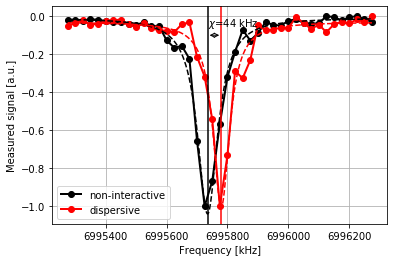

chi=44.9 kHz
g=9.5 MHz


In [478]:
plt.plot(frequencies_range/1e3, high_power_sweep_values1, '-o', color='black', lw=2, label='non-interactive')
plt.plot(frequencies_range/1e3, low_power_sweep_values1,'-o', color='red', lw=2, label='dispersive')

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_high_power1), color='black', ls='--')
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power1), color='red', ls='--')

plt.axvline(x=popt_low_power1[0]/1e3, color='red')
plt.axvline(x=popt_high_power1[0]/1e3, color='black')

chi=popt_low_power1[0]-popt_high_power1[0]
plt.annotate("", xy=(popt_low_power1[0]/1e3, -.1), xytext=(popt_high_power1[0]/1e3, -.1), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\chi$={:d} kHz".format(int(chi/1e3)), xy=(popt_high_power1[0]/1e3, -.05), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.legend()
plt.show()

print(r'chi={:.1f} kHz'.format((popt_low_power1[0]-popt_high_power1[0])/1e3))
Delta=abs(backend_defaults.meas_freq_est[qubit] - backend_defaults.qubit_freq_est[qubit])
print(r'g={:.1f} MHz'.format(np.sqrt(chi*Delta)/1e6))

chi = popt_low_power1[0]-popt_high_power1[0]
g = np.sqrt(chi*Delta)/1e6

In [479]:
chi_1 = chi
chi_1

44919.64657020569

In [480]:
g_1 = g
g_1

9.529189431909755

In [481]:
frequency_sweep_high_power = assemble(pulse_high_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_high_power = backend.run(frequency_sweep_high_power)
job_monitor(job_high_power)

high_power_sweep_results = job_high_power.result(timeout=120)

Job Status: job has successfully run


In [482]:
high_power_sweep_values = []
for i in range(len(high_power_sweep_results.results)):
    res_high_power = high_power_sweep_results.get_memory(i)
    high_power_sweep_values.append(res_high_power[qubit])

high_power_sweep_values2 = process_reflective_measurement(frequencies_range,high_power_sweep_values)

popt_high_power2,_=fit_lorentzian(frequencies_range,high_power_sweep_values2)

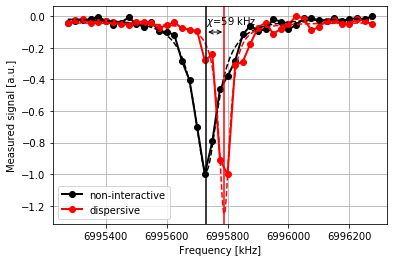

chi=59.6 kHz
g=11.0 MHz


In [483]:
plt.plot(frequencies_range/1e3, high_power_sweep_values2, '-o', color='black', lw=2, label='non-interactive')
plt.plot(frequencies_range/1e3, low_power_sweep_values2,'-o', color='red', lw=2, label='dispersive')

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_high_power2), color='black', ls='--')
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power2), color='red', ls='--')

plt.axvline(x=popt_low_power2[0]/1e3, color='red')
plt.axvline(x=popt_high_power2[0]/1e3, color='black')

chi=popt_low_power2[0]-popt_high_power2[0]
plt.annotate("", xy=(popt_low_power2[0]/1e3, -.1), xytext=(popt_high_power2[0]/1e3, -.1), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\chi$={:d} kHz".format(int(chi/1e3)), xy=(popt_high_power2[0]/1e3, -.05), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.legend()
plt.show()

print(r'chi={:.1f} kHz'.format((popt_low_power2[0]-popt_high_power2[0])/1e3))
Delta=abs(backend_defaults.meas_freq_est[qubit] - backend_defaults.qubit_freq_est[qubit])
print(r'g={:.1f} MHz'.format(np.sqrt(chi*Delta)/1e6))

chi = popt_low_power2[0]-popt_high_power2[0]
g = np.sqrt(chi*Delta)/1e6

In [484]:
chi_2 = chi
chi_2

59644.453300476074

In [485]:
g_2 = g
g_2

10.98051795062963

In [486]:
frequency_sweep_high_power = assemble(pulse_high_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_high_power = backend.run(frequency_sweep_high_power)
job_monitor(job_high_power)

high_power_sweep_results = job_high_power.result(timeout=120)

Job Status: job has successfully run


In [487]:
high_power_sweep_values = []
for i in range(len(high_power_sweep_results.results)):
    res_high_power = high_power_sweep_results.get_memory(i)
    high_power_sweep_values.append(res_high_power[qubit])

high_power_sweep_values3 = process_reflective_measurement(frequencies_range,high_power_sweep_values)

popt_high_power3,_=fit_lorentzian(frequencies_range,high_power_sweep_values3)

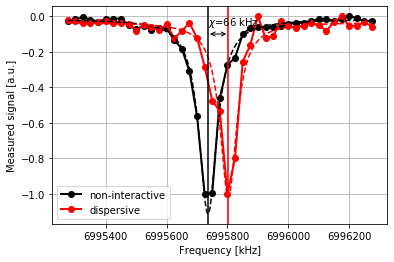

chi=66.8 kHz
g=11.6 MHz


In [488]:
plt.plot(frequencies_range/1e3, high_power_sweep_values3, '-o', color='black', lw=2, label='non-interactive')
plt.plot(frequencies_range/1e3, low_power_sweep_values3,'-o', color='red', lw=2, label='dispersive')

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_high_power3), color='black', ls='--')
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power3), color='red', ls='--')

plt.axvline(x=popt_low_power3[0]/1e3, color='red')
plt.axvline(x=popt_high_power3[0]/1e3, color='black')

chi=popt_low_power3[0]-popt_high_power3[0]
plt.annotate("", xy=(popt_low_power3[0]/1e3, -.1), xytext=(popt_high_power3[0]/1e3, -.1), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\chi$={:d} kHz".format(int(chi/1e3)), xy=(popt_high_power3[0]/1e3, -.05), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.legend()
plt.show()

print(r'chi={:.1f} kHz'.format((popt_low_power3[0]-popt_high_power3[0])/1e3))
Delta=abs(backend_defaults.meas_freq_est[qubit] - backend_defaults.qubit_freq_est[qubit])
print(r'g={:.1f} MHz'.format(np.sqrt(chi*Delta)/1e6))

chi = popt_low_power3[0]-popt_high_power3[0]
g = np.sqrt(chi*Delta)/1e6

In [489]:
chi_3 = chi
chi_3

66849.01218509674

In [490]:
g_3 = g
g_3

11.62479471254869

In [491]:
frequency_sweep_high_power = assemble(pulse_high_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_high_power = backend.run(frequency_sweep_high_power)
job_monitor(job_high_power)

high_power_sweep_results = job_high_power.result(timeout=120)

Job Status: job has successfully run


In [492]:
high_power_sweep_values = []
for i in range(len(high_power_sweep_results.results)):
    res_high_power = high_power_sweep_results.get_memory(i)
    high_power_sweep_values.append(res_high_power[qubit])

high_power_sweep_values4 = process_reflective_measurement(frequencies_range,high_power_sweep_values)

popt_high_power4,_=fit_lorentzian(frequencies_range,high_power_sweep_values4)

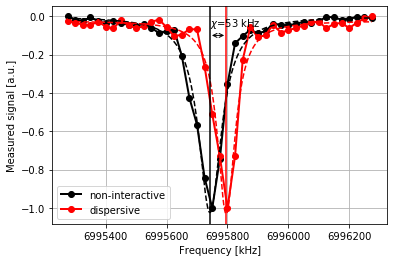

chi=53.5 kHz
g=10.4 MHz


In [493]:
plt.plot(frequencies_range/1e3, high_power_sweep_values4, '-o', color='black', lw=2, label='non-interactive')
plt.plot(frequencies_range/1e3, low_power_sweep_values4,'-o', color='red', lw=2, label='dispersive')

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_high_power4), color='black', ls='--')
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power4), color='red', ls='--')

plt.axvline(x=popt_low_power4[0]/1e3, color='red')
plt.axvline(x=popt_high_power4[0]/1e3, color='black')

chi=popt_low_power4[0]-popt_high_power4[0]
plt.annotate("", xy=(popt_low_power4[0]/1e3, -.1), xytext=(popt_high_power4[0]/1e3, -.1), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\chi$={:d} kHz".format(int(chi/1e3)), xy=(popt_high_power4[0]/1e3, -.05), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.legend()
plt.show()

print(r'chi={:.1f} kHz'.format((popt_low_power4[0]-popt_high_power4[0])/1e3))
Delta=abs(backend_defaults.meas_freq_est[qubit] - backend_defaults.qubit_freq_est[qubit])
print(r'g={:.1f} MHz'.format(np.sqrt(chi*Delta)/1e6))

chi = popt_low_power4[0]-popt_high_power4[0]
g = np.sqrt(chi*Delta)/1e6

In [494]:
chi_4 = chi
chi_4

53513.70391845703

In [495]:
g_4 = g
g_4

10.400885152174075

In [496]:
frequency_sweep_high_power = assemble(pulse_high_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_high_power = backend.run(frequency_sweep_high_power)
job_monitor(job_high_power)

high_power_sweep_results = job_high_power.result(timeout=120)

Job Status: job has successfully run


In [497]:
high_power_sweep_values = []
for i in range(len(high_power_sweep_results.results)):
    res_high_power = high_power_sweep_results.get_memory(i)
    high_power_sweep_values.append(res_high_power[qubit])

high_power_sweep_values5 = process_reflective_measurement(frequencies_range,high_power_sweep_values)

popt_high_power5,_=fit_lorentzian(frequencies_range,high_power_sweep_values5)

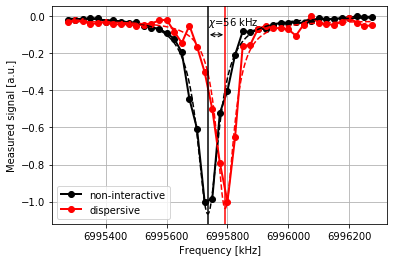

chi=57.0 kHz
g=10.7 MHz


In [498]:
plt.plot(frequencies_range/1e3, high_power_sweep_values5, '-o', color='black', lw=2, label='non-interactive')
plt.plot(frequencies_range/1e3, low_power_sweep_values5,'-o', color='red', lw=2, label='dispersive')

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_high_power5), color='black', ls='--')
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power5), color='red', ls='--')

plt.axvline(x=popt_low_power5[0]/1e3, color='red')
plt.axvline(x=popt_high_power5[0]/1e3, color='black')

chi=popt_low_power5[0]-popt_high_power5[0]
plt.annotate("", xy=(popt_low_power5[0]/1e3, -.1), xytext=(popt_high_power5[0]/1e3, -.1), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\chi$={:d} kHz".format(int(chi/1e3)), xy=(popt_high_power5[0]/1e3, -.05), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.legend()
plt.show()

print(r'chi={:.1f} kHz'.format((popt_low_power5[0]-popt_high_power5[0])/1e3))
Delta=abs(backend_defaults.meas_freq_est[qubit] - backend_defaults.qubit_freq_est[qubit])
print(r'g={:.1f} MHz'.format(np.sqrt(chi*Delta)/1e6))

chi = popt_low_power5[0]-popt_high_power5[0]
g = np.sqrt(chi*Delta)/1e6

In [499]:
chi_5 = chi
chi_5

56989.50929450989

In [500]:
g_5 = g
g_5

10.733349074741232

In [534]:
chi_avgs = np.mean([high_power_sweep_values1, high_power_sweep_values2, high_power_sweep_values3, high_power_sweep_values4, high_power_sweep_values5], axis=0)

In [533]:
chi_stds = np.std([high_power_sweep_values1, high_power_sweep_values2, high_power_sweep_values3, high_power_sweep_values4, high_power_sweep_values5], axis=0)

In [543]:
len(frequencies_range)

41

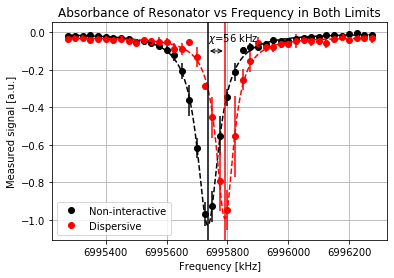

chi=56.1 kHz
g=10.6 MHz


In [557]:
plt.plot(frequencies_range/1e3, np.real(chi_avgs), '-o', color='black', label='Non-interactive', ls = 'none')
plt.plot(frequencies_range/1e3, np.real(kappa_avgs),'-o', color='red', label='Dispersive', ls = 'none')

plt.errorbar(frequencies_range/1e3, chi_avgs, yerr=chi_stds, color='black', ls = 'none')
plt.errorbar(frequencies_range/1e3, kappa_avgs, yerr=kappa_stds, color='red', ls = 'none')

popt_high_power,_ = fit_lorentzian(frequencies_range,chi_avgs)

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_high_power), color='black', ls='--')
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power), color='red', ls='--')

plt.axvline(x=popt_low_power[0]/1e3, color='red')
plt.axvline(x=popt_high_power[0]/1e3, color='black')

chi=popt_low_power[0]-popt_high_power[0]
plt.annotate("", xy=(popt_low_power[0]/1e3, -.1), xytext=(popt_high_power[0]/1e3, -.1), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\chi$={:d} kHz".format(int(chi/1e3)), xy=(popt_high_power[0]/1e3, -.05), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.legend()
plt.title('Absorbance of Resonator vs Frequency in Both Limits')
plt.show()

print(r'chi={:.1f} kHz'.format((popt_low_power[0]-popt_high_power[0])/1e3))
Delta=abs(backend_defaults.meas_freq_est[qubit] - backend_defaults.qubit_freq_est[qubit])
print(r'g={:.1f} MHz'.format(np.sqrt(chi*Delta)/1e6))

chi = popt_low_power[0]-popt_high_power[0]
g = np.sqrt(chi*Delta)/1e6

In [623]:
avg_g = g

In [624]:
avg_chi = chi

In [627]:
Delta

2021508586.1661701

In [625]:
#avg_g = (g_1 + g_2 + g_3 + g_4 + g_5) / 5
avg_g

10.64530030575244

In [626]:
std_g = np.sqrt(((g_1 - avg_g)**2 + (g_2 - avg_g)**2 + (g_3 - avg_g)**2 + (g_4 - avg_g)**2 + (g_5 - avg_g)**2) / 5)
std_g

0.6906482459416238

In [572]:
#avg_chi = (chi_1 + chi_2 + chi_3 + chi_4 + chi_5) / 5
avg_chi

56058.34146595001

In [573]:
std_chi = np.sqrt(((chi_1 - avg_chi)**2 + (chi_2 - avg_chi)**2 + (chi_3 - avg_chi)**2 + (chi_4 - avg_chi)**2 + (chi_5 - avg_chi)**2) / 5)
std_chi

7220.963237855669

In [574]:
detuning = - avg_g**2 / avg_chi

In [575]:
detuning

-2021508586.16617

In [579]:
T_phi

3006.3202383729617

In [585]:
1/(T_phi)

0.0003326325609746771

In [593]:
n = avg_amp / (detuning**2 + (avg_kappa / 2)**2)

In [595]:
eta = avg_kappa**2 / (avg_kappa**2 + 4 * avg_chi**2)

In [596]:
eta * n * (4 * avg_chi**2) / avg_kappa

1.7390952285432757e-15

In [586]:
avg_kappa

70229.00276257984

In [587]:
avg_chi

56058.34146595001

In [592]:
avg_amp

0.14090025466819067

In [598]:
qubit_freq + detuning

2950312372.6819506

In [606]:
detuning

-2021508586.16617

In [601]:
last_freqs[33]

6996620669.0

In [604]:
(frequencies_range[18])

6995775000.0

In [557]:
frequencies_range[13]

6991620669.0

In [558]:
last_freqs = frequencies_range

In [574]:
last_freqs[33]

6996620669.0

In [604]:
avg_chi

56058.34146595001

In [605]:
avg_kappa

70229.00276257984

In [376]:
#do rabi osc with avg freq. Get out avg params

In [ ]:
#with newfound pi pulse, do T1, T2 times

In [ ]:
#set up hamiltonian

In [ ]:
#with hamiltonian, implement gates in q-ctrl.

In [ ]:
#access higher level states?
#lind-bland dynamics?

In [ ]:
#build a multi-circuit system with copies of this qubit??? Add a twin qubit and couple them. Make a third qubit that is tunable 
#can do original system that way!!!

In [41]:
backend.configuration().hamiltonian

{'description': 'Qubits are modeled as Duffing oscillators. In this case, the system includes higher energy states, i.e. not just |0> and |1>. The Pauli operators are generalized via the following set of transformations:\n\n$(\\mathbb{I}-\\sigma_{i}^z)/2 \\rightarrow O_i \\equiv b^\\dagger_{i} b_{i}$,\n\n$\\sigma_{+} \\rightarrow b^\\dagger$,\n\n$\\sigma_{-} \\rightarrow b$,\n\n$\\sigma_{i}^X \\rightarrow b^\\dagger_{i} + b_{i}$.\n\nQubits are coupled through resonator buses. The provided Hamiltonian has been projected into the zero excitation subspace of the resonator buses leading to an effective qubit-qubit flip-flop interaction. The qubit resonance frequencies in the Hamiltonian are the cavity dressed frequencies and not exactly what is returned by the backend defaults, which also includes the dressing due to the qubit-qubit interactions.\n\nQuantities are returned in angular frequencies, with units 2*pi*GHz.\n\nWARNING: Currently not all system Hamiltonian information is available

In [241]:
backend_defaults.qubit_freq_est[qubit]

4971859893.026022

In [242]:
backend_defaults.meas_freq_est[qubit]

6993370669.0

In [243]:
backend_defaults.qubit_freq_est[qubit] - backend_defaults.meas_freq_est[qubit]

-2021510775.973978